In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set_style("ticks")
sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tsfresh import select_features, extract_features
from pprint import pprint

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
df_raw = pd.read_csv('seasonality_input.csv')

In [5]:
df_raw['week_start_date'] = pd.to_datetime(df_raw['week_start_date'])
df_raw = df_raw.set_index('week_start_date')

In [10]:
df_JP = df_raw.filter(regex='JP')

In [11]:
df_JP = df_JP.loc['2018-09-03':'2020-12-28']

In [15]:
# Create a copy of DataFrame here for EDA/other operations
df = df_JP.copy()

In [16]:
# Check number of rows and columns in data
df.shape

(122, 167)

This has all the features - revenue/users/oreders/spends/impressions/clicks as well exogenous features. Let's separate them for an easier analysis!

## Feature Analysis

In [17]:
# List of all feature names
all_features = df.columns

### Exogenous features as used in previous run

### External Features [Indicator Variables]

Separate external features and create dataframes for each for easier analysis!

In [19]:
# Get features which only have 0s and 1s in them!
dummy_variables_01 = list(df.apply({0, 1}.issuperset).loc[lambda x : x].index)

In [20]:
# Weather
weather_features=  ['JP_main_Clear+Clouds','JP_main_Clouds','JP_main_Clouds+Rain','JP_main_Clouds+Snow',\
                   'JP_extraordinary_weather','JP_snow','JP_thunderstorm','JP_feels_like_cold',\
                   'JP_feels_like_comfortable','JP_feels_like_hot','JP_>=4_wet_days','JP_>=4_rained',\
                   'JP_wet_days_in_weekend_1','JP_rained_on_weekend_1','JP_windy+cold']

# Holidays (PH)
holiday_features = ['JP_Christmas','JP_December_Bank_Holiday','JP_December_Solstice','JP_Golden_Week',\
                    'JP_Hiroshima_Memorial_Day','JP_June_Solstice','JP_Mountain_Day','JP_Sea_Day',\
                    'JP_Valentine_Day','JP_New_Year','JP_January_Bank_Holiday','JP_Emperor_Birthday',\
                    'JP_Coronation_Day','JP_Nagasaki_Memorial_Day','JP_Sports_Day',\
                   'JP_Type_National_holiday','JP_Type_Bank_holiday','JP_Type_Observance','JP_Type_Season']

# Seasonal Patterns (Weekly/Monthly) - More things can be experimented with here!
# Can be considered as part of PH
weekly_monthly_features = ['JP_Long_Weekend', 'JP_Non_Working_Day_>=2', 'JP_First_Week_of_Month', 'JP_Last_Week_of_Month']

# Events
events_features = ['JP_game_launches','JP_game_launches_tentpole']

# Covid
covid_features = ['JP_deaths_all_ages', 'JP_p_scores_all_ages', 'JP_new_cases', 'JP_total_cases']

In [21]:
# Let's create dataframes for the external features
df_weather = df[weather_features]
df_holiday = df[holiday_features]
df_weekly_monthly = df[weekly_monthly_features]
df_events = df[events_features]
df_covid = df[covid_features]

### Internal features

In [22]:
# Dataframes for internal features
df_users = df.filter(regex='acquired')
df_revenue = df.filter(regex='rev')
df_orders = df.filter(regex='orders')
df_spends = df.filter(regex='Cost')
df_clicks = df.filter(regex='Clicks')
df_impressions = df.filter(regex='Impressions')
df_impressions_no_lag = df.filter(regex='Impressions$')

In [23]:
# Internal features - Users acquired / revenue / orders / spends / clicks / impressions
users_features = list(df_users.columns)
revenue_features = list(df_revenue.columns)
orders_features = list(df_orders.columns)
spends_features = list(df_spends.columns)
clicks_features = list(df_clicks.columns)
impressions_features = list(df_impressions.columns)

In [24]:
# Final dictionary of features
features_dict = {'users': users_features,\
                 'revenue': revenue_features,\
                 'orders': orders_features,\
                 'spends': spends_features,\
                 'clicks': clicks_features,\
                 'impressions': impressions_features,\
                 'weather': weather_features,\
                 'holidays': holiday_features,\
                 'events': events_features,\
                 'weekly_monthly': weekly_monthly_features,\
                 'covid': covid_features}

In [25]:
# And all dataframes in one list!
all_dfs = [df_users, df_revenue, df_orders, df_spends, df_clicks, df_impressions,\
          df_weather, df_events, df_holiday, df_covid, df_weekly_monthly]

In [26]:
# Check that all features sum up to total number number of features
len(users_features) + len(revenue_features) + len(orders_features)+len(spends_features)+len(clicks_features)+len(impressions_features)+\
len(covid_features) + len(weather_features) + len(holiday_features) + len(weekly_monthly_features) + len(events_features)

167

In [27]:
all_channels = ['dv360','gdn','offnetdisplay','offnetvideo','onnetsem','offnetsem',\
                'twitter','youtube','social','video','onnetshopping','total']

## Creating Input and Output

We are going to model on two inputs (response) - clicks and impressions, and three targets - Revenue (28d cohort), Users, Cost per Buyer (CPB)! So i n total we will be working with 6 combinations:

- Clicks : Revenue
- Clicks : Users
- Clicks : CPB
- Impressions : Revenue
- Impressions : Users
- Impressions : CPB

Let's create these dataframes for further analysis

In [28]:
X_clicks = pd.concat([df_clicks, df_weather, df_events, df_holiday, df_covid, df_weekly_monthly], axis=1, join="inner")
X_impressions = pd.concat([df_impressions, df_weather, df_events, df_holiday, df_covid, df_weekly_monthly], axis=1, join="inner")

Let's drop total clicks and total impressions from the respective dataframes.

In [29]:
X_clicks = X_clicks.drop(['JP_total_Clicks'], axis=1)
X_impressions = X_impressions.drop(['JP_total_Impressions'], axis=1)

In [30]:
# Target
y_target_revenue = df['JP_total_npu+rpu_rev_28d_cohort']
y_target_users = df['JP_total_npu+rpu_acquired']
y_target_cpb = df['JP_total_Cost']/df['JP_total_npu+rpu_acquired']

In [31]:
y_target_cpb.name = 'CPB'

# Exploratory Data Analysis

### Revenue vs Spends

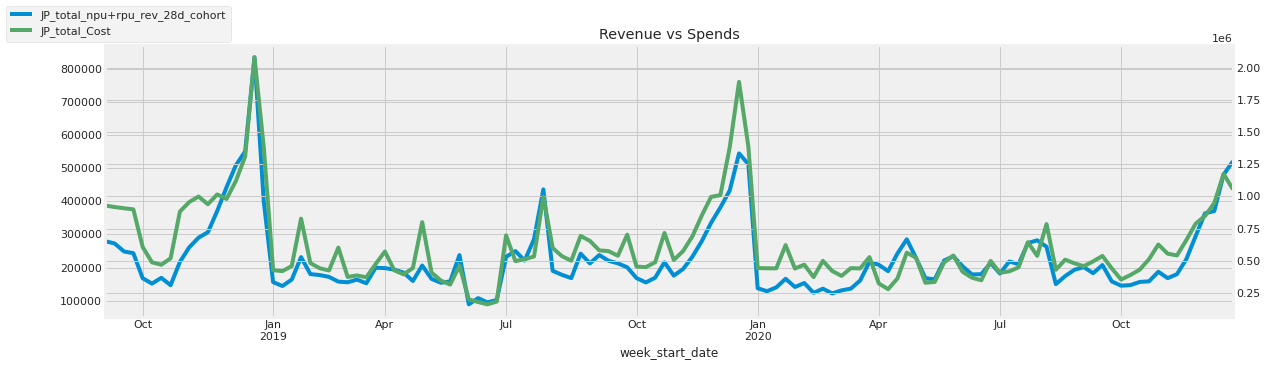

In [32]:
ax = df_JP['JP_total_npu+rpu_rev_28d_cohort'].plot(figsize=(18,5),legend=False)
ax2 = ax.twinx()
df_JP['JP_total_Cost'].plot(title="Revenue vs Spends", figsize=(18,5),legend=False, color='g')
ax.figure.legend(loc='upper left')
plt.show()

### Visualizing KPIs

#### Revenue/Users

<AxesSubplot: title={'center': 'Users'}, xlabel='week_start_date'>

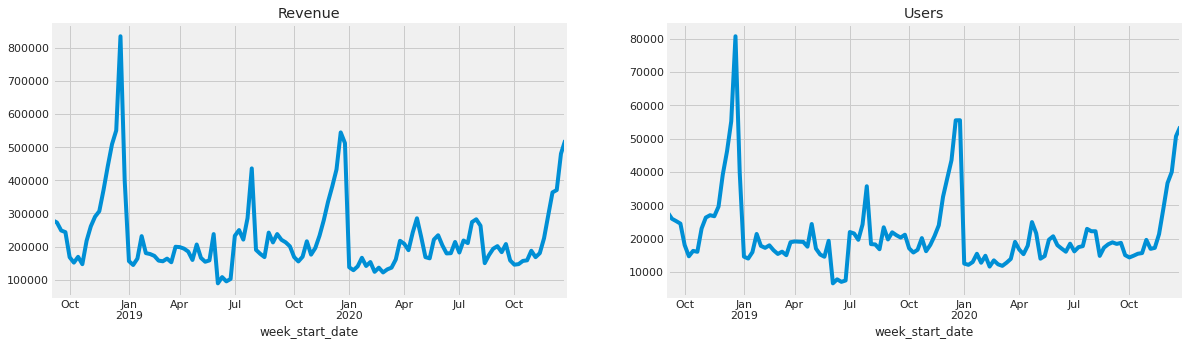

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)
df_JP['JP_total_npu+rpu_rev_28d_cohort'].plot(title="Revenue", figsize=(18,5),legend=False, ax=ax1)
y_target_users.plot(title="Users", figsize=(18,5),legend=False, ax=ax2)

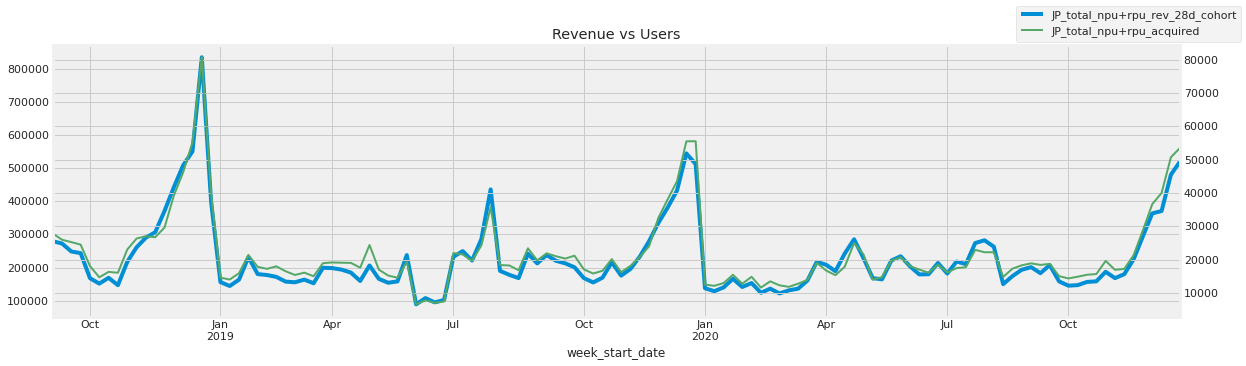

In [34]:
ax = df_JP['JP_total_npu+rpu_rev_28d_cohort'].plot(figsize=(18,5),legend=False)
ax2 = ax.twinx()
y_target_users.plot(title="Revenue vs Users", figsize=(18,5),legend=False, ax=ax2, color='g', lw=2)
ax.figure.legend()
plt.show()

Revenue and Users seem to follow the same trend, which kind of makes sense!

#### Cost per Buyer (User)

<AxesSubplot: title={'center': 'Cost Per Buyer (User)'}>

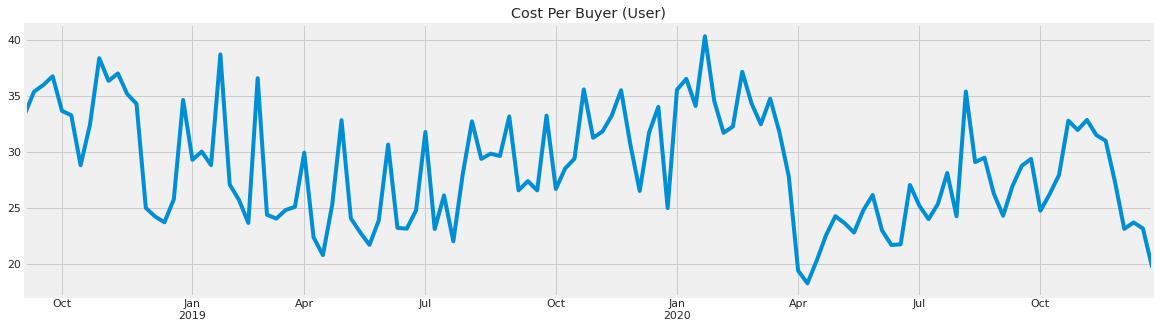

In [35]:
y_target_cpb.plot(title="Cost Per Buyer (User)", figsize=(18,5),legend=False, xlabel='')

It is interetsting to note that the **Cost Per Buyer** KPI does not seem to display much of a seasonality pattern other than end of year fall (expected) and a strong fall around April 2020 which can be assigned to Covid-19 first lockdown! Let's plot it on top of revenue and see how the patterns align!

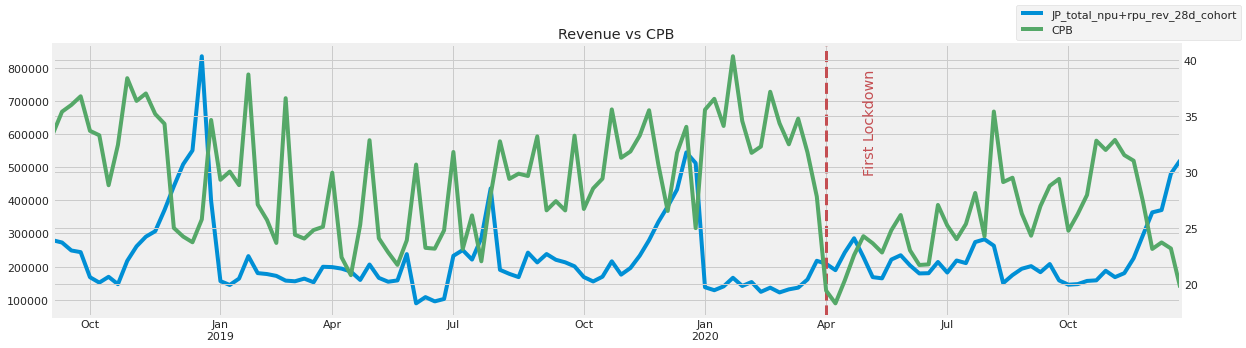

In [36]:
ax = df_JP['JP_total_npu+rpu_rev_28d_cohort'].plot(figsize=(18,5),legend=False,  xlabel='')
ax2 = ax.twinx()
y_target_cpb.plot(title="Revenue vs CPB", figsize=(18,5),legend=False, ax=ax2, color='g', xlabel='')
ax.figure.legend()
ax.axvline(pd.to_datetime('2020-04-01'), color='r', linestyle='--', lw=3)
plt.text(pd.to_datetime('2020-05-01'),30,'First Lockdown',rotation=90,color='r', fontsize='x-large')
plt.show()

It would be interesting to see in the modeling process how changing the KPI from Revenue to CPB affects the outcome and what insights do we get from it. Also it is perhaps safe to assume that Revenue and Users will probably end up giving same insights so we can drop the modeling with Users as a target variable.

### Year on Year Plots for Revenue

In [38]:
pv_rev = pd.pivot_table(df_JP, index=df.index.isocalendar().week, columns=df.index.year,
                    values='JP_total_npu+rpu_rev_28d_cohort', aggfunc='sum')

<AxesSubplot: title={'center': 'YoY Revenue'}, xlabel='Week Number'>

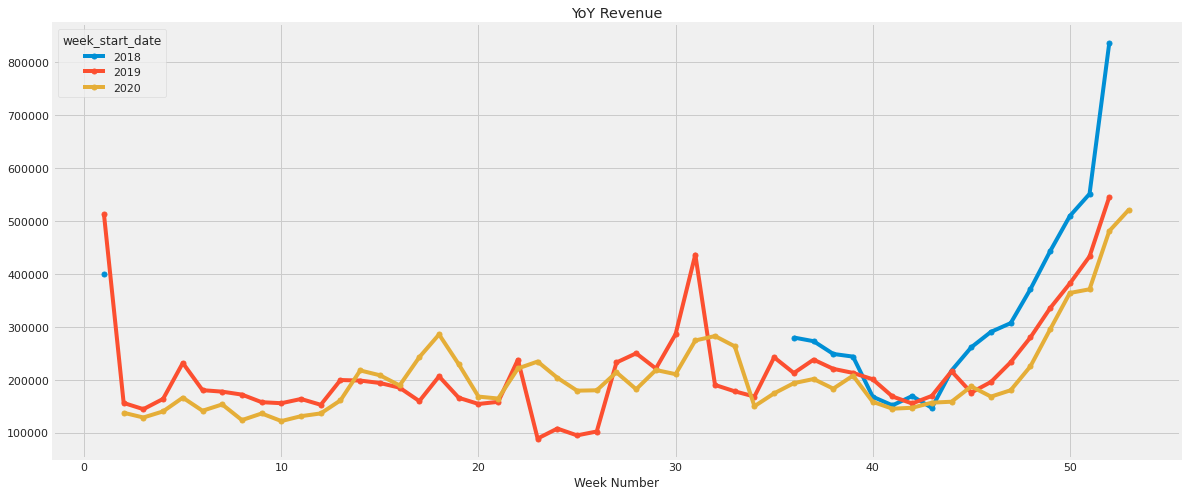

In [39]:
pv_rev.plot(figsize=(18,8), style='.-', markersize=10, title='YoY Revenue', xlabel='Week Number')

In [40]:
pv_rev_month = pd.pivot_table(df_JP, index=df.index.month, columns=df.index.year,
                    values='JP_total_npu+rpu_rev_28d_cohort', aggfunc='sum')

<AxesSubplot: title={'center': 'YoY Revenue Monthly'}, xlabel='week_start_date'>

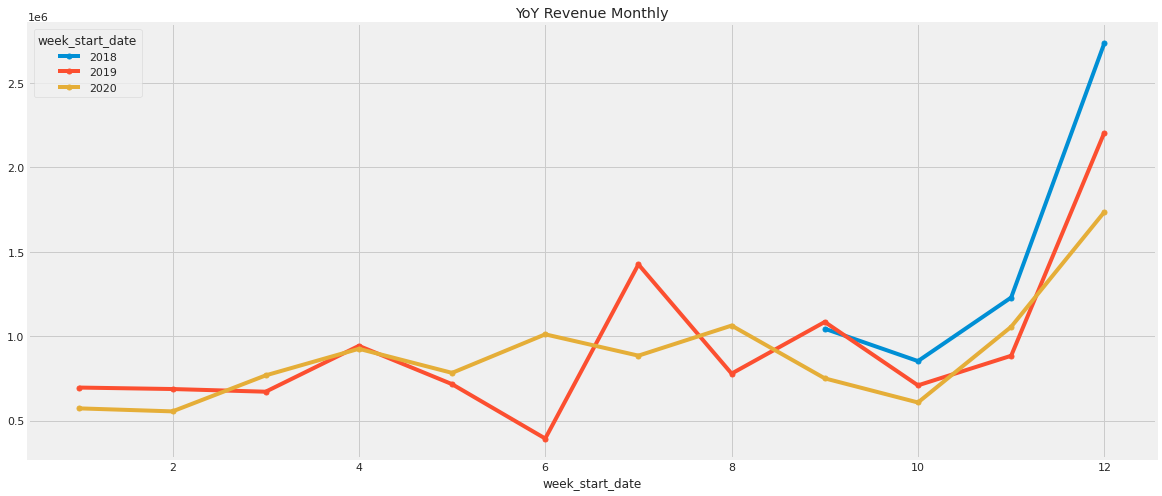

In [41]:
pv_rev_month.plot(figsize=(18,8), style='.-', markersize=10, title='YoY Revenue Monthly')

In [42]:
pv_rev_quarter = pd.pivot_table(df_JP, index=df.index.quarter, columns=df.index.year,
                    values='JP_total_npu+rpu_rev_28d_cohort', aggfunc='sum')

<AxesSubplot: title={'center': 'YoY Revenue Quarterly'}, xlabel='week_start_date'>

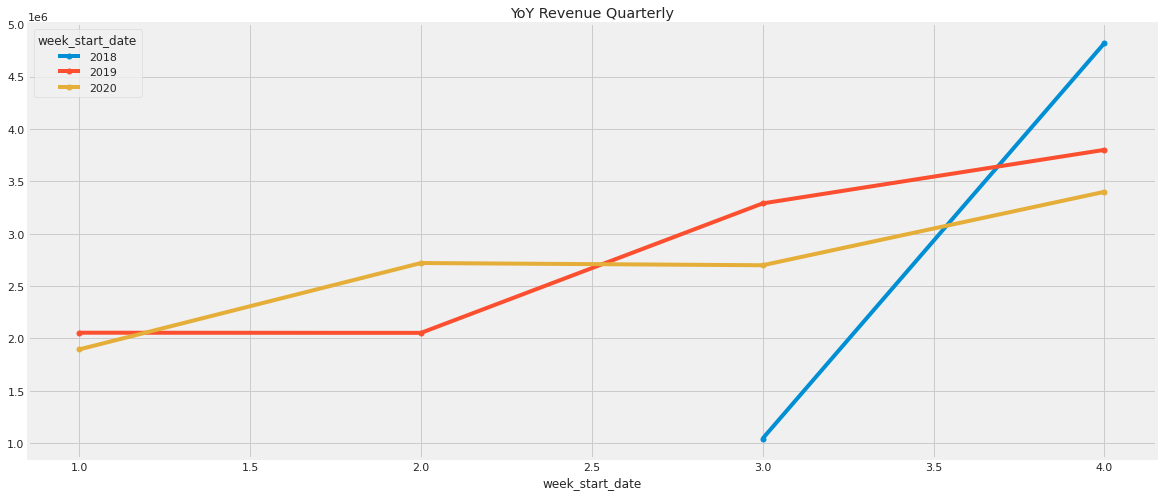

In [43]:
pv_rev_quarter.plot(figsize=(18,8), style='.-', markersize=10, title='YoY Revenue Quarterly')

### Visualizing features time-series - spends/clicks/impressions across channels!

### <A> Spends

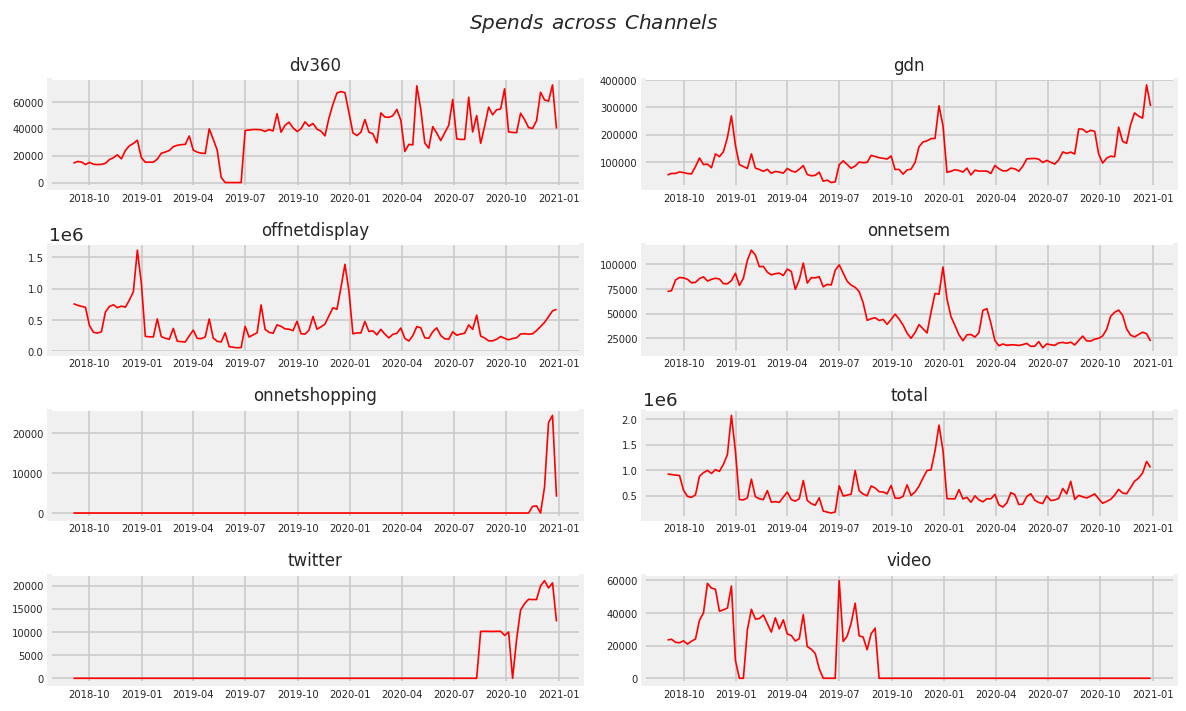

In [44]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_spends[df_spends.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df_spends.columns[i].split('_')[1], fontsize='medium')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

fig.suptitle('$Spends \: \: across \: \: Channels$')
plt.tight_layout();

### <A> Clicks

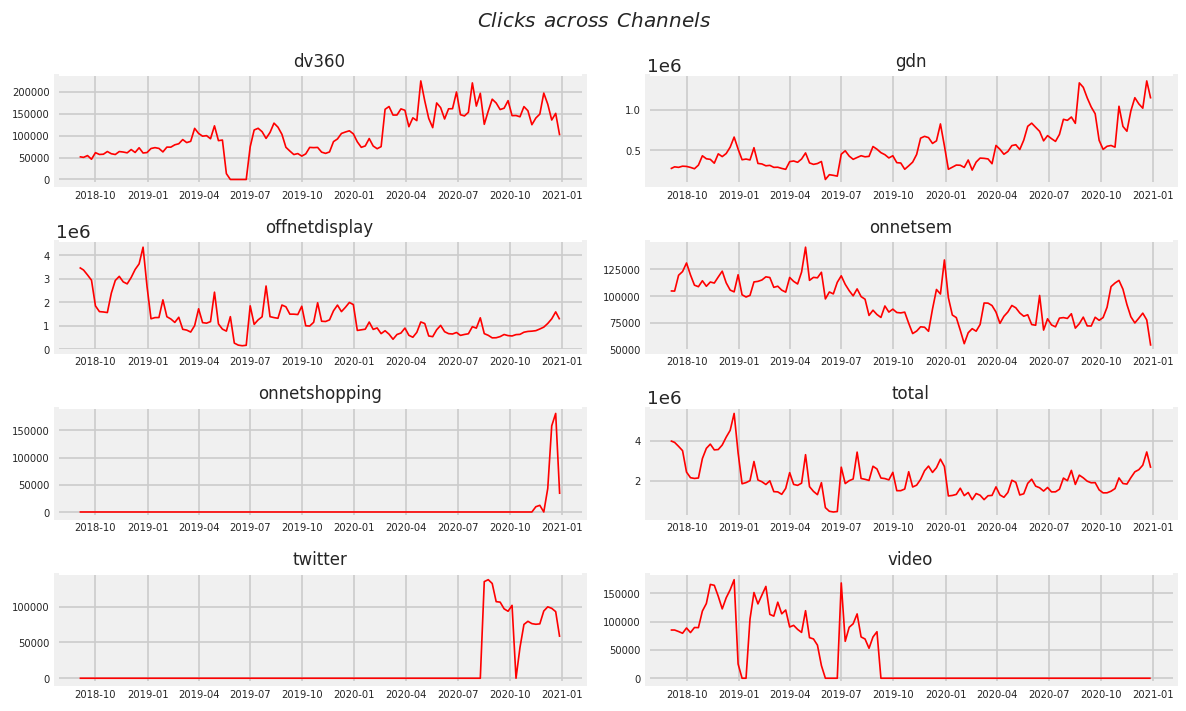

In [45]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_clicks[df_clicks.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df_clicks.columns[i].split('_')[1], fontsize='medium')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

fig.suptitle('$Clicks \: \: across \: \: Channels$')
plt.tight_layout();

### <A> Impressions

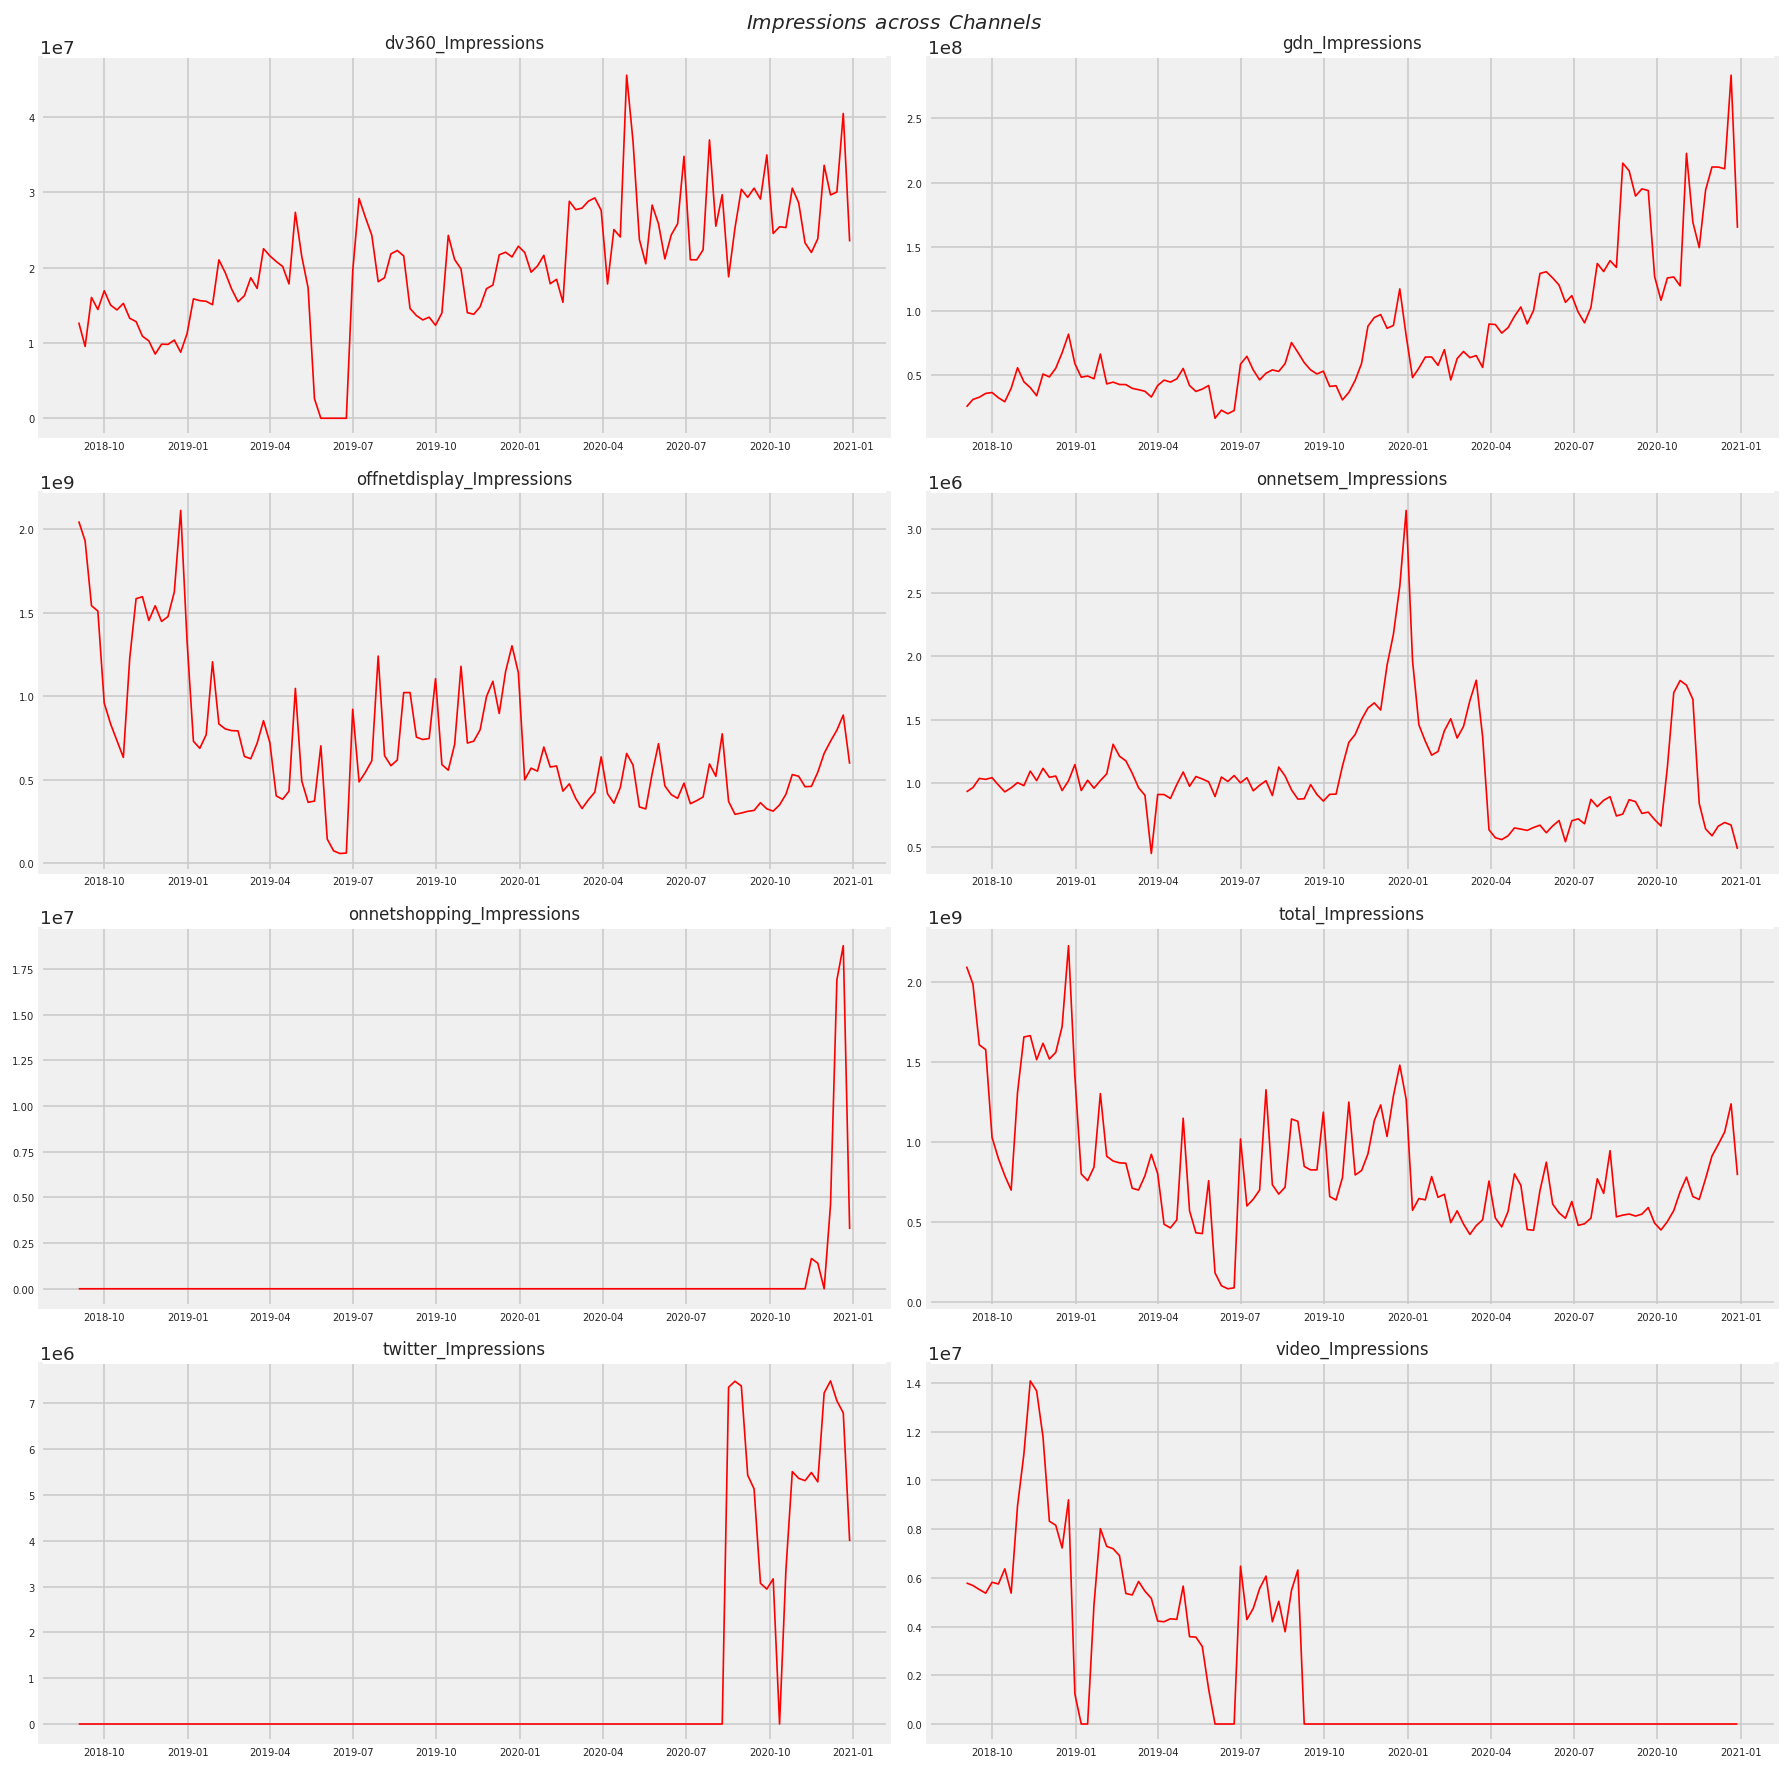

In [48]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(15,15))
for i, ax in enumerate(axes.flatten()):
    data = df_impressions[df_impressions.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df_impressions.columns[i][3:], fontsize='medium')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

fig.suptitle('$Impressions \: \: across \: \: Channels$')
plt.tight_layout();

It seems that there is no data for **onnetshopping** and **twitter** for most of the time period, and also for **video** for almost half of the period. We will drop these channels from our analysis.

### Dropping onnetshopping, twitter, and video from further analysis!

In [49]:
X_clicks = X_clicks.drop(['JP_onnetshopping_Clicks', 'JP_twitter_Clicks', 'JP_video_Clicks'], axis=1)

In [51]:
X_impressions = X_impressions.drop(['JP_onnetshopping_Impressions', 'JP_twitter_Impressions', 'JP_video_Impressions'], axis=1)

Before moving further, we can also check the different revenue time-series!

In [52]:
df_revenue_npu = df_revenue.filter(regex='npu_rev_28d_cohort$')
df_revenue_rpu = df_revenue.filter(regex='._rpu_rev_28d_cohort$')
df_revenue_npu_rpu = df_revenue.filter(regex='.[+]rpu_rev_28d_cohort$')

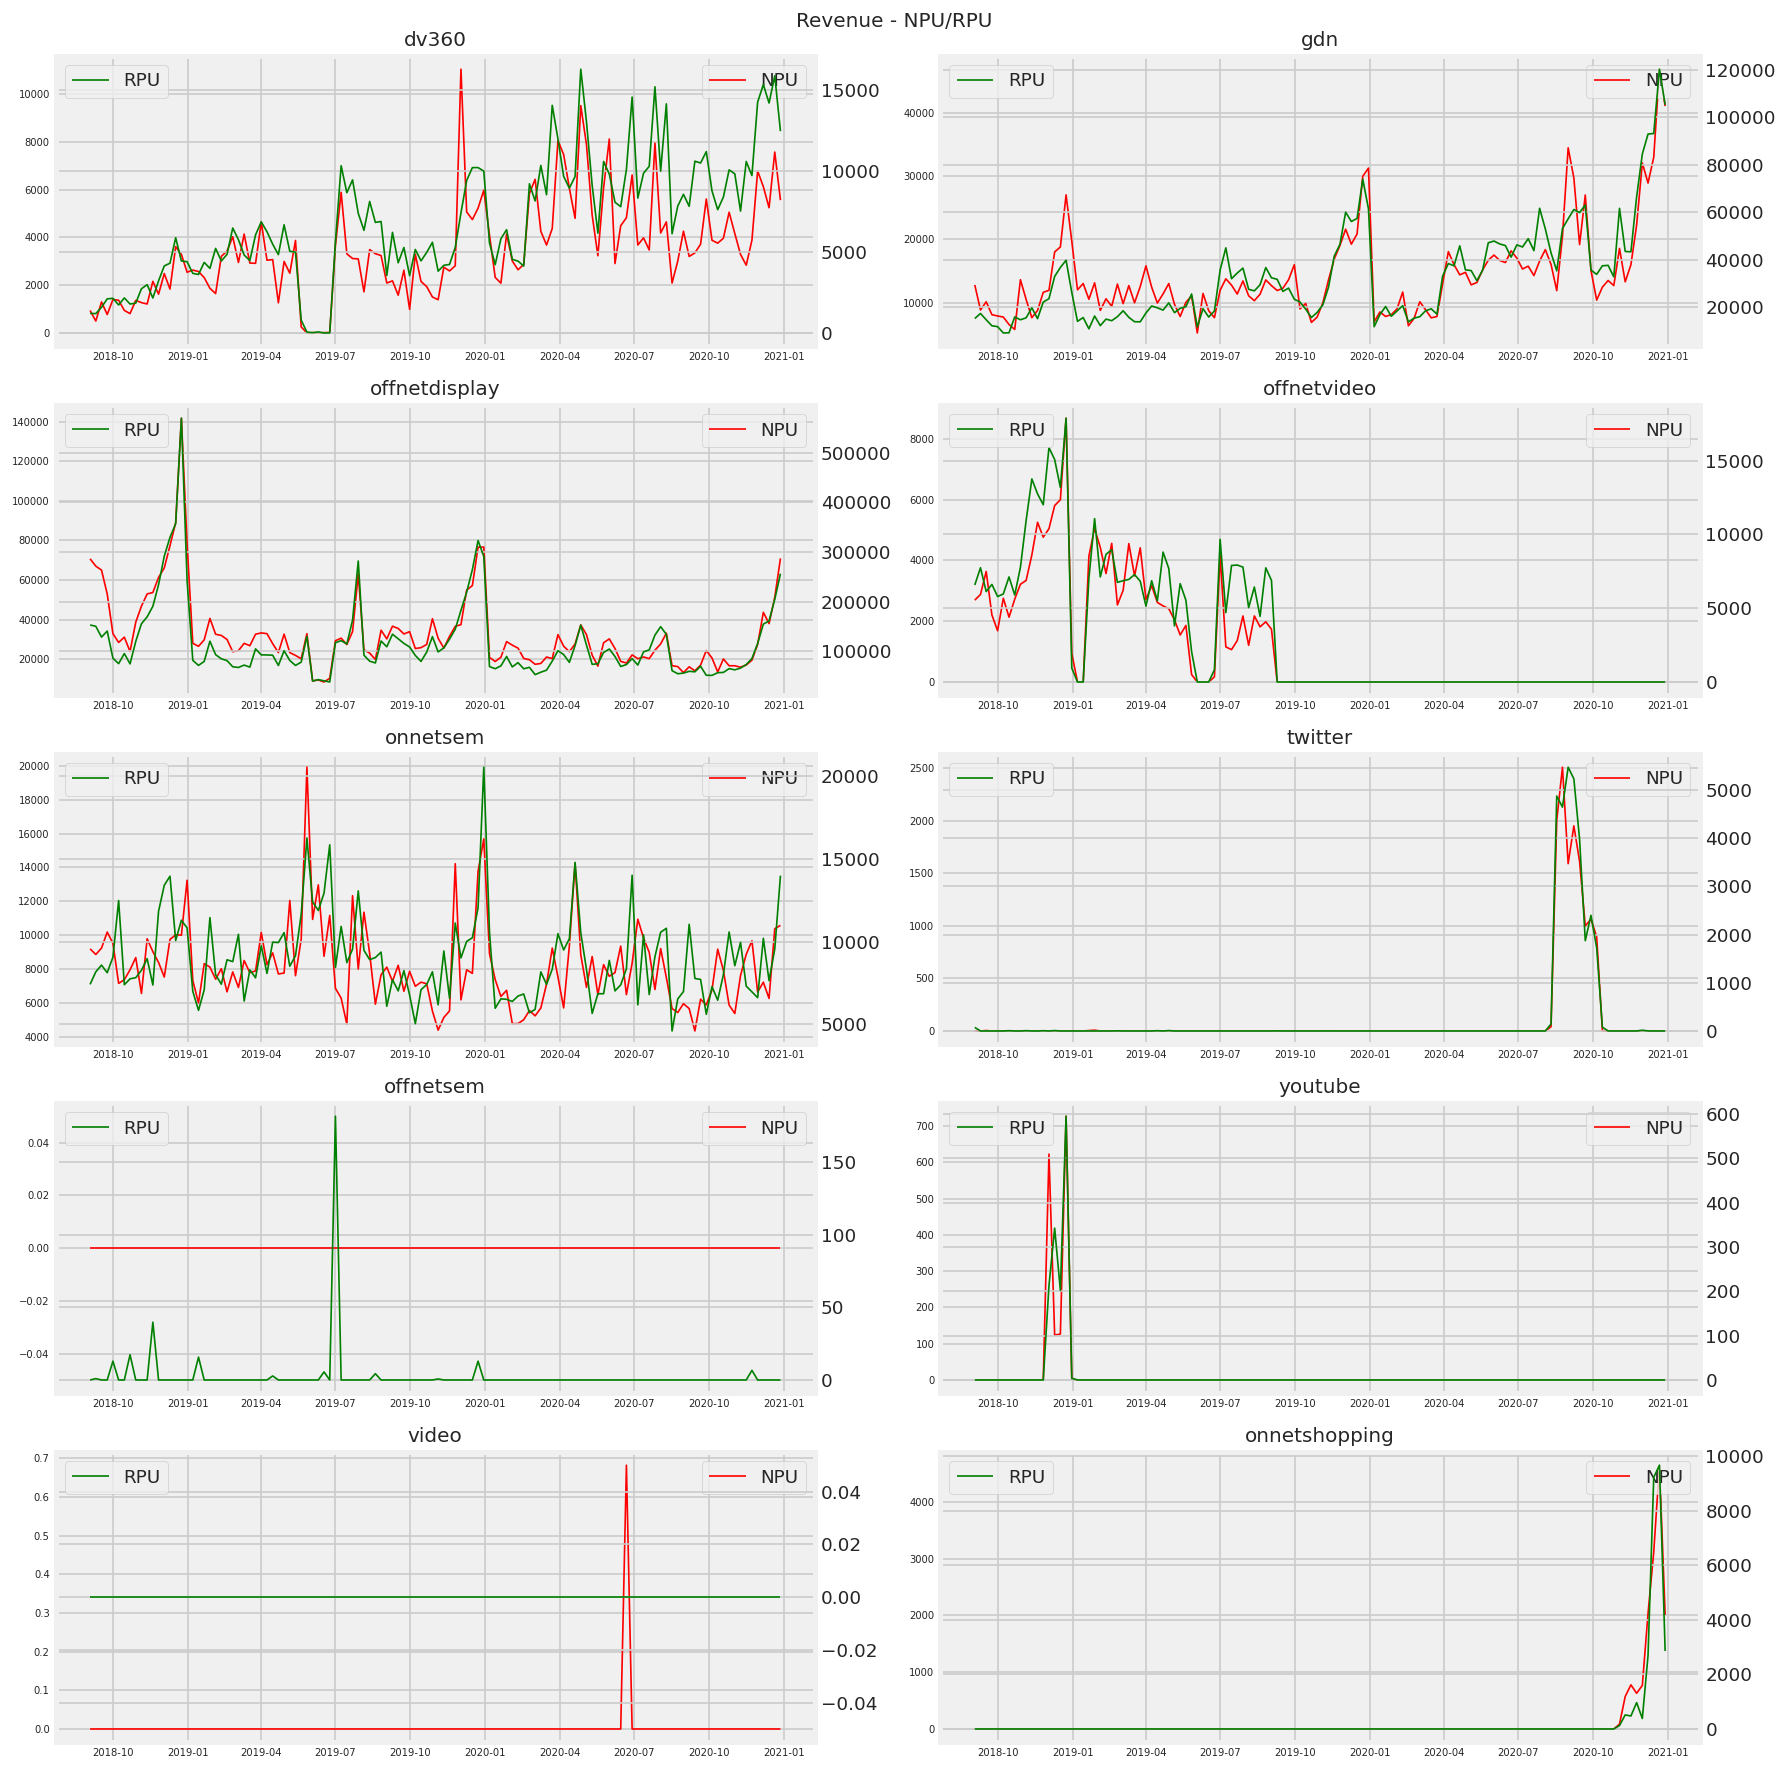

In [53]:
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(15,15))
for i, ax in enumerate(axes.flatten()):
    data = df_revenue_npu[df_revenue_npu.columns[i]]
    ax.plot(data, color='red', linewidth=1,label='NPU')
    ax.legend(loc=1)
    ax2 = ax.twinx()
    data2 = df_revenue_rpu[df_revenue_rpu.columns[i]]
    ax2.plot(data2, color='green', linewidth=1,label='RPU')
    ax2.legend(loc=2)
    # Decorations
    ax.set_title(df_revenue_npu.columns[i].split('_')[1], fontsize='large')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

fig.suptitle('Revenue - NPU/RPU')
plt.tight_layout();

### Distribution of Spends across Channels and clicks/impression response to understand channel importance

In [54]:
channel_names = ['dv360', 'gdn', 'offnetdisplay', 'onnetsem', 'onnetshopping', 'twitter', 'video']

In [55]:
all_spends = df.drop(['JP_total_Cost'], axis=1).filter(regex='Cost').sum().reset_index()
all_spends['index'] = all_spends['index'].apply(lambda x: x.split('_')[1])

all_clicks = X_clicks.filter(regex='Click').sum().reset_index()
all_clicks['index'] = all_clicks['index'].apply(lambda x: x.split('_')[1])

all_impressions = X_impressions.filter(regex='Impressions$').sum().reset_index()
all_impressions['index'] = all_impressions['index'].apply(lambda x: x.split('_')[1])

In [56]:
all_spends.rename(columns = {'index':'Channel', 0: 'Spends'}, inplace = True)
all_clicks.rename(columns = {'index':'Channel', 0: 'Clicks'}, inplace = True)
all_impressions.rename(columns = {'index':'Channel', 0: 'Impressions'}, inplace = True)

In [57]:
all_spends['pct'] = (all_spends['Spends']/all_spends['Spends'].sum())*100.0
all_clicks['pct'] = (all_clicks['Clicks']/all_clicks['Clicks'].sum())*100.0
all_impressions['pct'] = (all_impressions['Impressions']/all_impressions['Impressions'].sum())*100.0

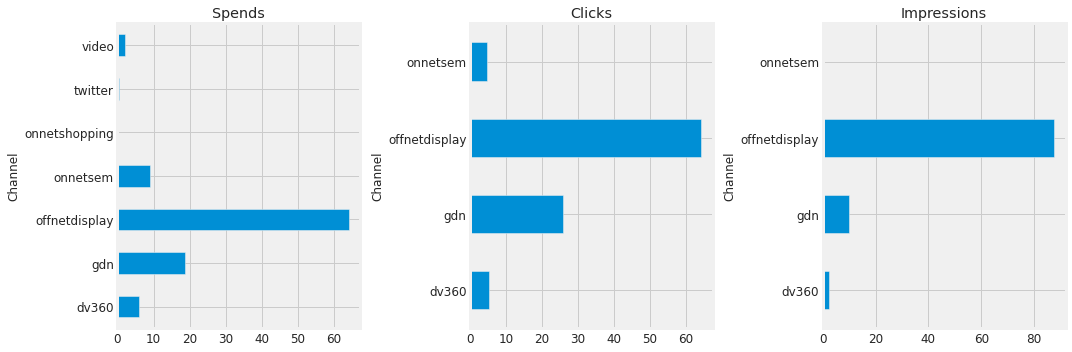

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
all_spends.plot(kind='barh', x='Channel', y = 'pct', ax=ax1, legend = False, fontsize=12, figsize=(15,5), title='Spends')
all_clicks.plot(kind='barh', x='Channel', y = 'pct', ax=ax2, legend = False, fontsize=12, figsize=(15,5), title='Clicks')
all_impressions.plot(kind='barh', x='Channel', y = 'pct', ax=ax3, legend = False, fontsize=12, figsize=(15,5), title='Impressions')

plt.tight_layout()
plt.show()

### Looking for features with zero variance

In [59]:
X_clicks.sum()

JP_dv360_Clicks              1.274507e+07
JP_gdn_Clicks                6.416194e+07
JP_offnetdisplay_Clicks      1.597071e+08
JP_onnetsem_Clicks           1.151236e+07
JP_main_Clear+Clouds         2.900000e+01
JP_main_Clouds               6.400000e+01
JP_main_Clouds+Rain          2.800000e+01
JP_main_Clouds+Snow          1.000000e+00
JP_extraordinary_weather     4.400000e+01
JP_snow                      3.600000e+01
JP_thunderstorm              8.000000e+00
JP_feels_like_cold           8.900000e+01
JP_feels_like_comfortable    1.900000e+01
JP_feels_like_hot            1.400000e+01
JP_>=4_wet_days              4.400000e+01
JP_>=4_rained                7.000000e+01
JP_wet_days_in_weekend_1     4.900000e+01
JP_rained_on_weekend_1       7.000000e+01
JP_windy+cold                6.900000e+01
JP_game_launches             1.000000e+01
JP_game_launches_tentpole    0.000000e+00
JP_Christmas                 3.000000e+00
JP_December_Bank_Holiday     3.000000e+00
JP_December_Solstice         3.000

In [60]:
# Are there columns with close to 0 variance!
X_clicks.loc[:, np.isclose(0., X_clicks.var())]

JP_game_launches_tentpole
week_start_date                           
2018-09-03                               0
2018-09-10                               0
2018-09-17                               0
2018-09-24                               0
2018-10-01                               0
...                                    ...
2020-11-30                               0
2020-12-07                               0
2020-12-14                               0
2020-12-21                               0
2020-12-28                               0

[122 rows x 1 columns]

### Game launches tentpole is zero everywhere. Sigh! **REMOVE!**

In [61]:
X_clicks = X_clicks.drop(['JP_game_launches_tentpole'], axis=1)

### Correlation Heatmap

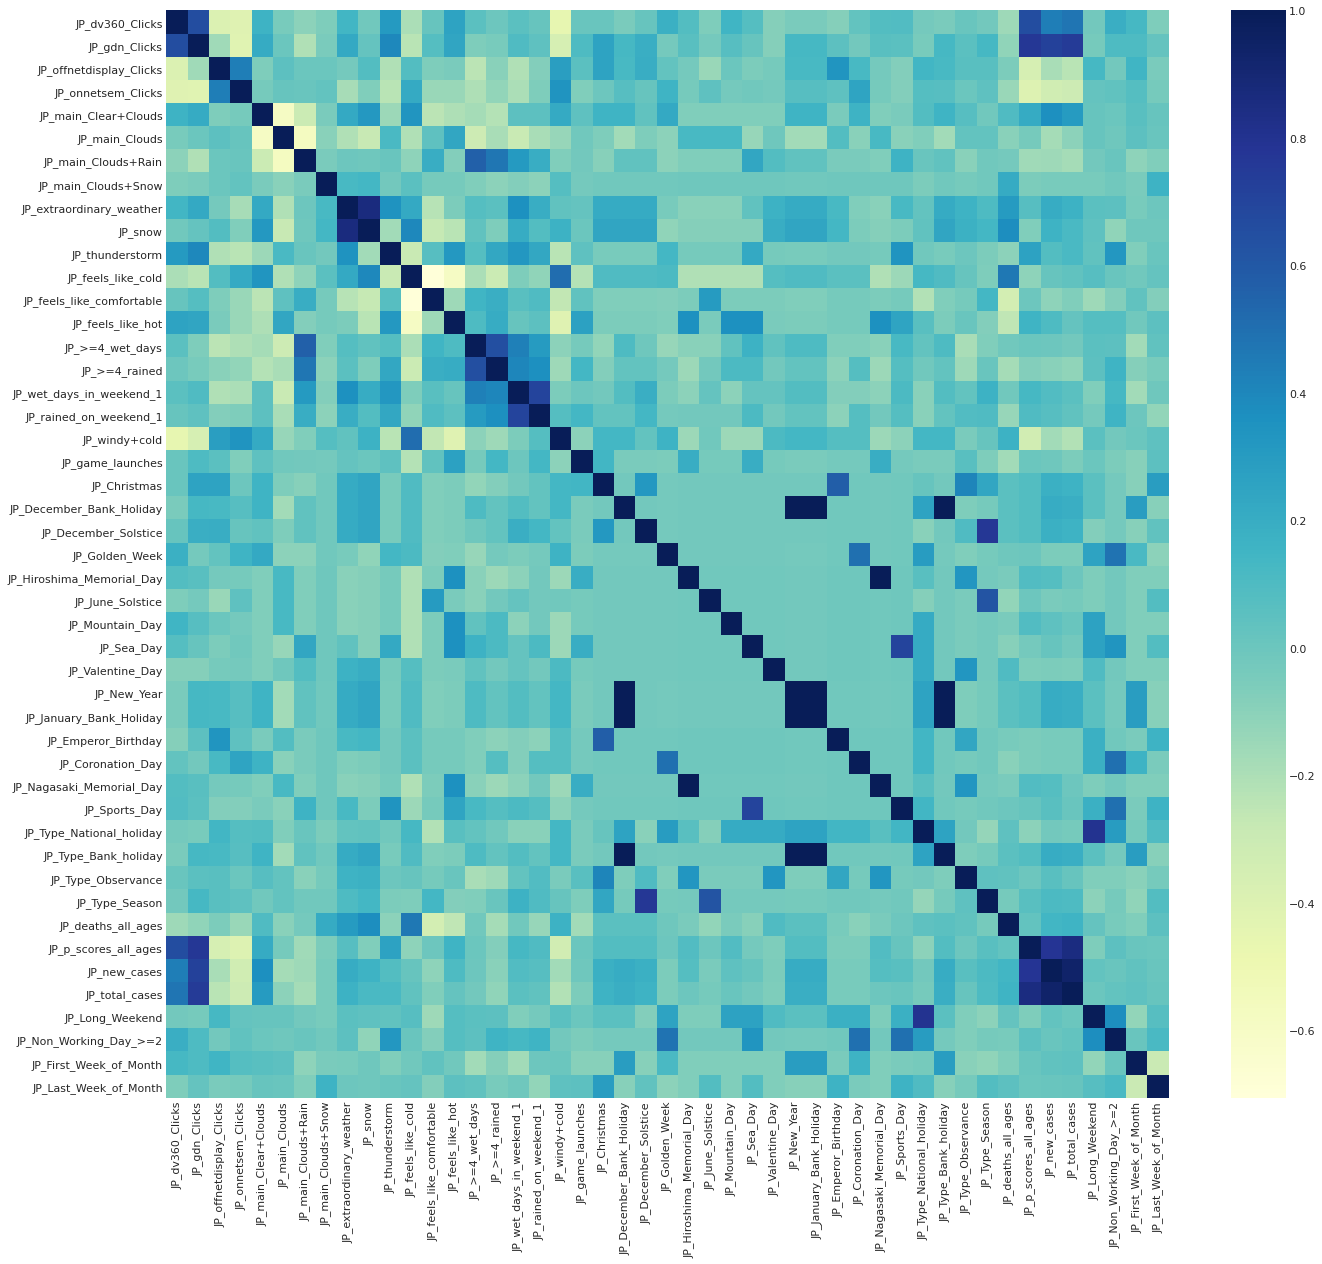

In [62]:
plt.figure(figsize  = (20,20))
sns.heatmap(X_clicks.corr(), annot = False, cmap="YlGnBu")
plt.show()

 ## Time-series specific EDA

In [63]:
def tsplot(y_series, lags=None, figsize=(12, 7), style='bmh'):
    '''
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        autolag = 'AIC'

        '''

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y_series.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y_series, autolag='AIC')[1]
        ts_ax.set_title('Time Series Analysis Plots - {0} \n Dickey-Fuller: p={1:0.5f}'.format(y_series.name, p_value))
        ts_ax.set_xlabel('')
        smt.graphics.plot_acf(y_series, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y_series, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [64]:
 def tsplot_with_differencing(y_series, lags=None, figsize=(18,9), style='bmh'):
        '''
        Plot time series (with acf) - original, 1st order differencing, 2nd order differencing

        '''
        with plt.style.context(style):
            fig, axes = plt.subplots(nrows=3, ncols=2, sharex=False, figsize=figsize)
            axes[0, 0].plot(y_series); axes[0, 0].set_title('Original Series')
            smt.graphics.plot_acf(y_series, lags=lags, ax=axes[0, 1])

            # 1st Differencing
            axes[1, 0].plot(y_series.diff()); axes[1, 0].set_title('1st Order Differencing')
            smt.graphics.plot_acf(y_series.diff().dropna(), lags=lags, ax=axes[1, 1])

            # 2nd Differencing
            axes[2, 0].plot(y_series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
            smt.graphics.plot_acf(y_series.diff().diff().dropna(), lags=lags, ax=axes[2, 1])
            plt.subplots_adjust(wspace=0.15, hspace=0.4)

## Revenue - TSA (ACF/PACF/Seasonal Decompose)

2023-06-26 16:44:14,406 [2452] WARNING  py.warnings:109: [JupyterRequire] /home/pgoel/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(



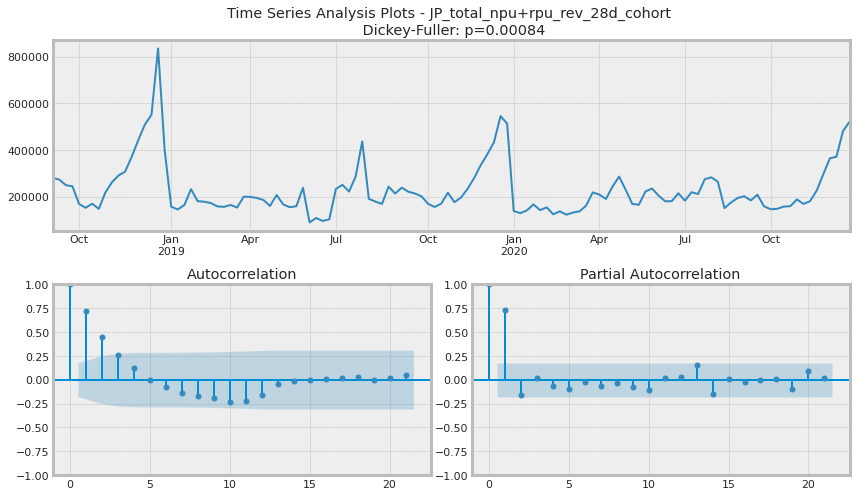

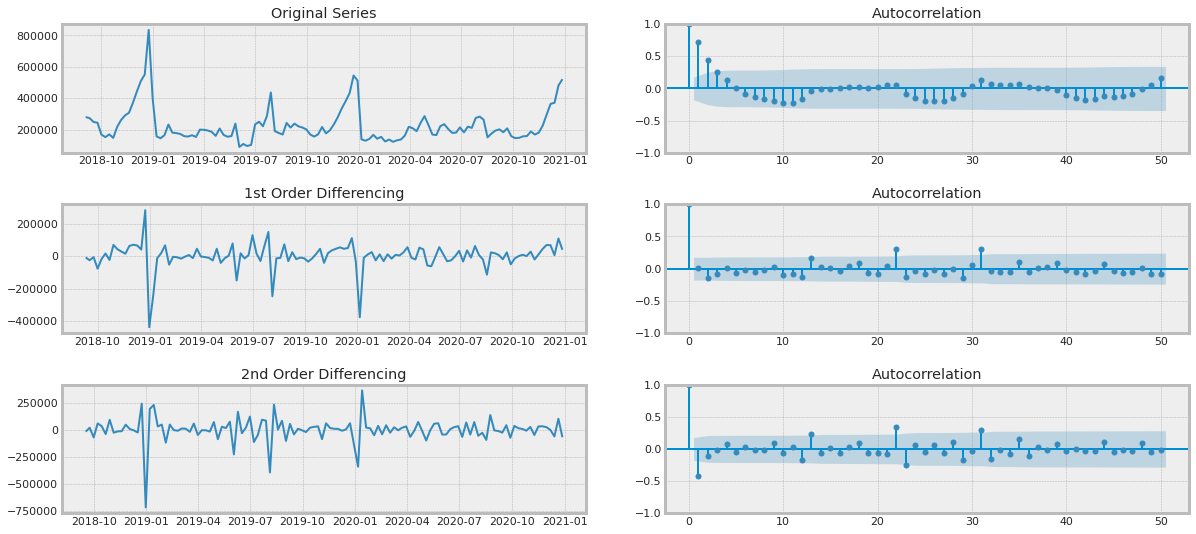

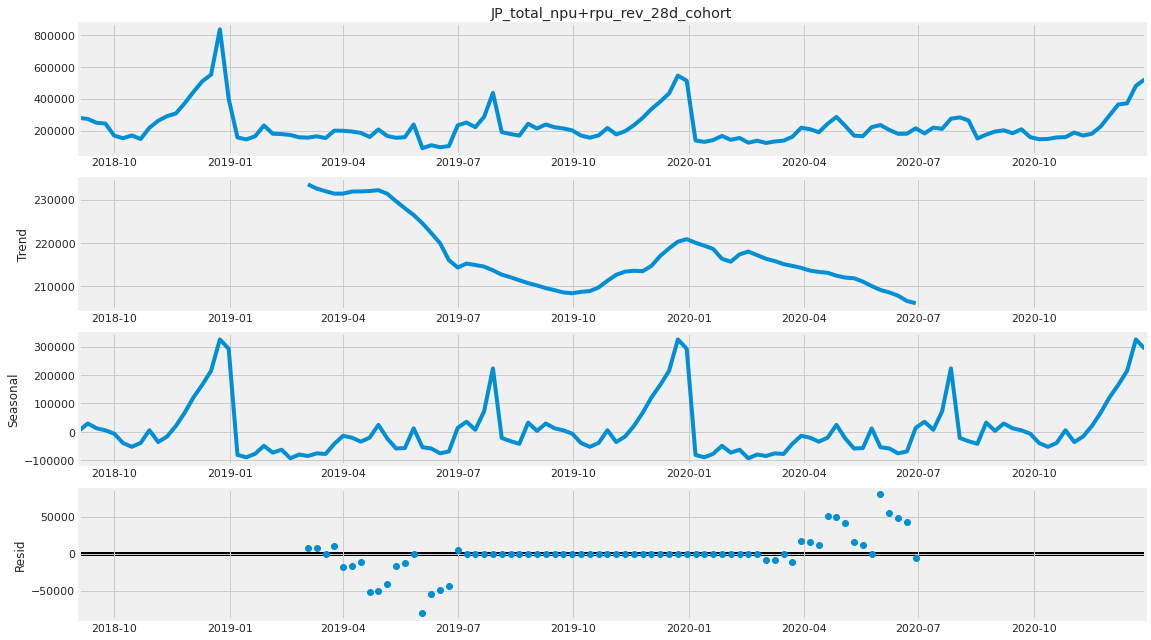

In [65]:
tsplot(df_JP['JP_total_npu+rpu_rev_28d_cohort'])
tsplot_with_differencing(df_JP['JP_total_npu+rpu_rev_28d_cohort'], lags=50)
sd_result = sm.tsa.seasonal_decompose(df_JP['JP_total_npu+rpu_rev_28d_cohort'], model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = sd_result.plot()

### Observations

Target series seems stationary after first differencing. This will be tested again. There ic clearly no trend in the series but we do have two seasonal peaks, end of December and somewhere in August!

## CPB - TSA (ACF/PACF/Seasonal Decompose)

2023-06-26 16:44:24,966 [2452] WARNING  py.warnings:109: [JupyterRequire] /home/pgoel/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(



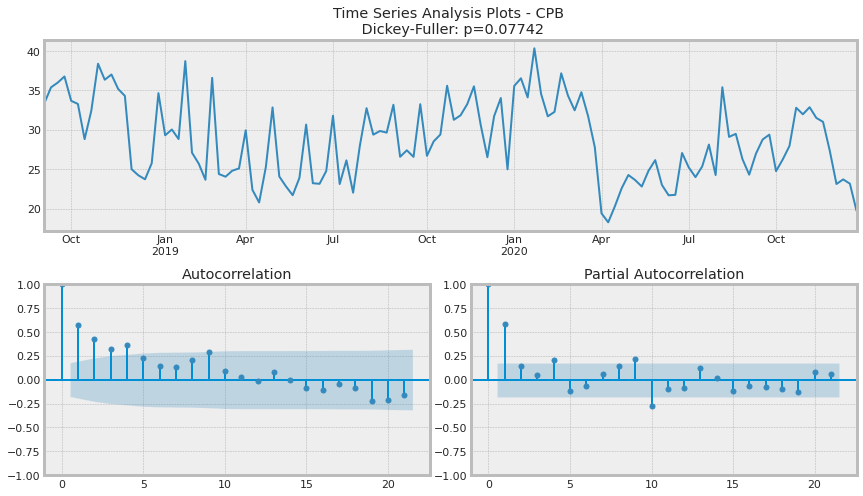

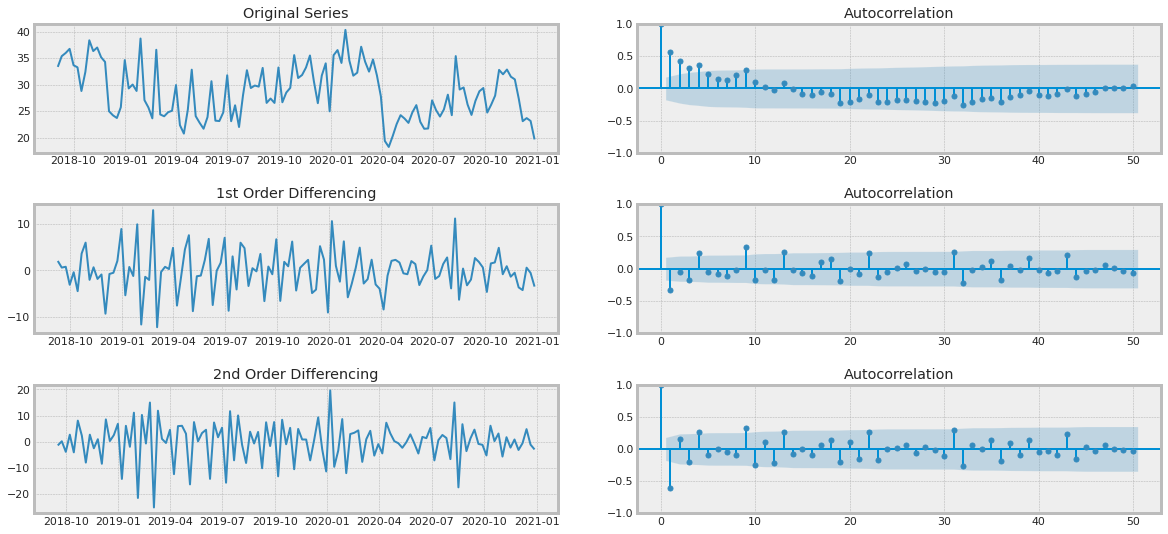

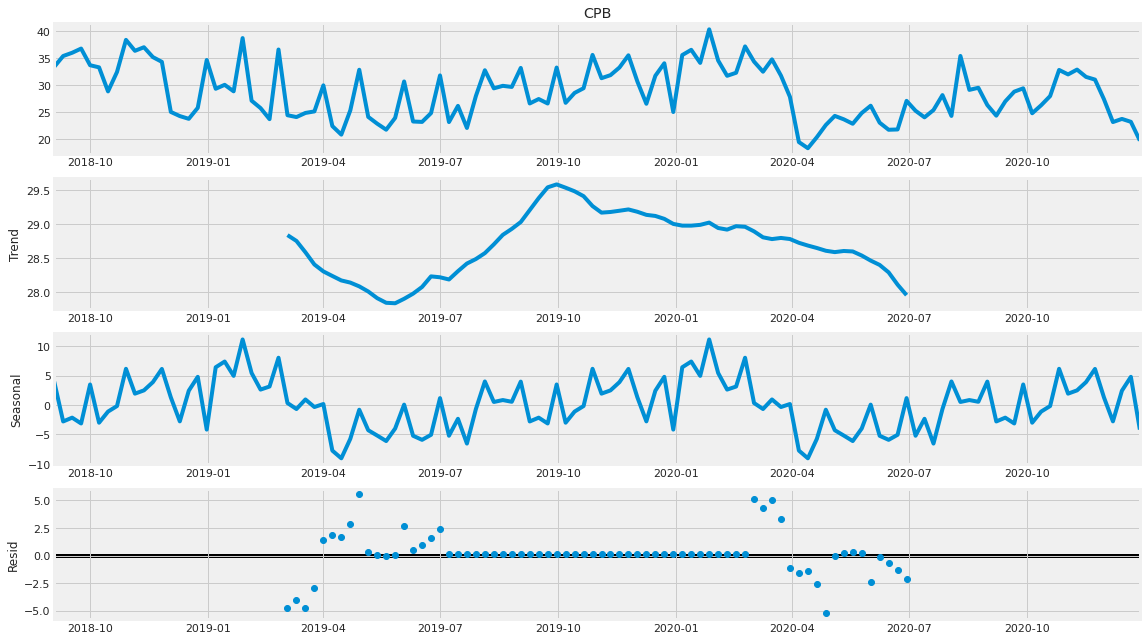

In [66]:
tsplot(y_target_cpb)
tsplot_with_differencing(y_target_cpb, lags=50)
sd_result = sm.tsa.seasonal_decompose(y_target_cpb, model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = sd_result.plot()

### Observations

## Feature Importance / Selection

## A. TSfresh

TSfresh <https://tsfresh.com/> individually tests the different features for significance (in a supervised setting, so the test is something like "is this feature useful to predict that output?") and keep the most significant ones using a procedure called the **Benjamini-Yekutieli procedure**.

Reference: https://stackoverflow.com/questions/58192180/the-algorithm-behind-tsfresh-select-features-method

### Revenue as Target

In [61]:
X_clicks_revenue_tsfresh = select_features(X_clicks, y_target_revenue)
X_impressions_revenue_tsfresh = select_features(X_impressions, y_target_revenue)

In [62]:
pprint(list(X_clicks_revenue_tsfresh.columns))

['JP_offnetdisplay_Clicks',
 'JP_gdn_Clicks',
 'JP_Christmas',
 'JP_December_Solstice',
 'JP_December_Bank_Holiday',
 'JP_New_Year',
 'JP_January_Bank_Holiday',
 'JP_Type_Bank_holiday']


In [63]:
pprint(list(X_impressions_revenue_tsfresh.columns))

['JP_offnetdisplay_Impressions',
 'JP_offnetdisplay_Impressions_lag_1',
 'JP_Christmas',
 'JP_December_Solstice',
 'JP_December_Bank_Holiday',
 'JP_Type_Bank_holiday',
 'JP_New_Year',
 'JP_January_Bank_Holiday']


## B. Random Forest

In [64]:
from sklearn.ensemble import RandomForestRegressor 

In [65]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)

In [66]:
# Click-Revenue
rfr.fit(X_clicks, y_target_revenue)

RandomForestRegressor(random_state=42)

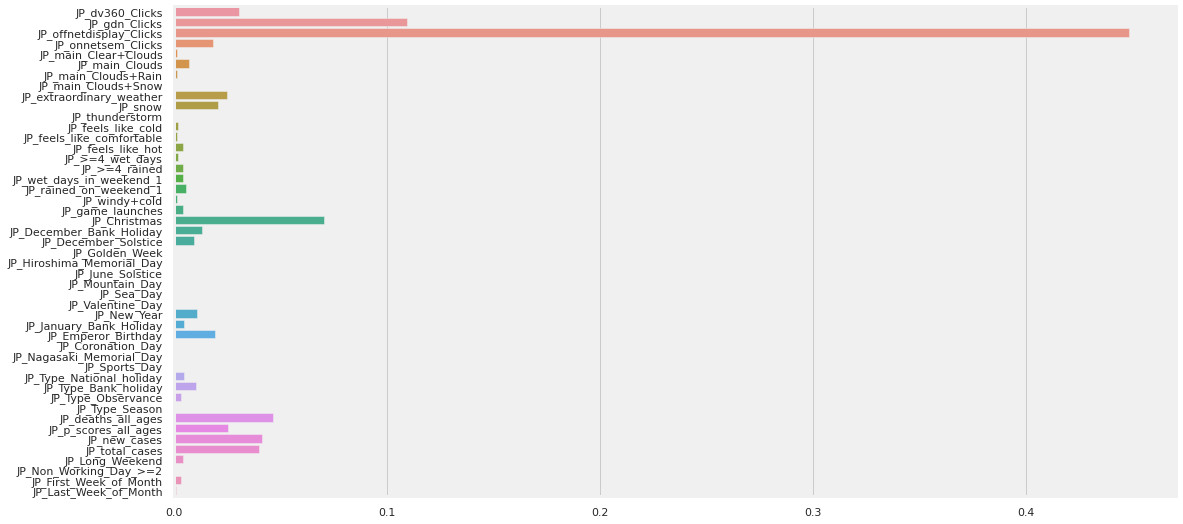

In [67]:
sns.barplot(x=rfr.feature_importances_, y=X_clicks.columns, orient='h');

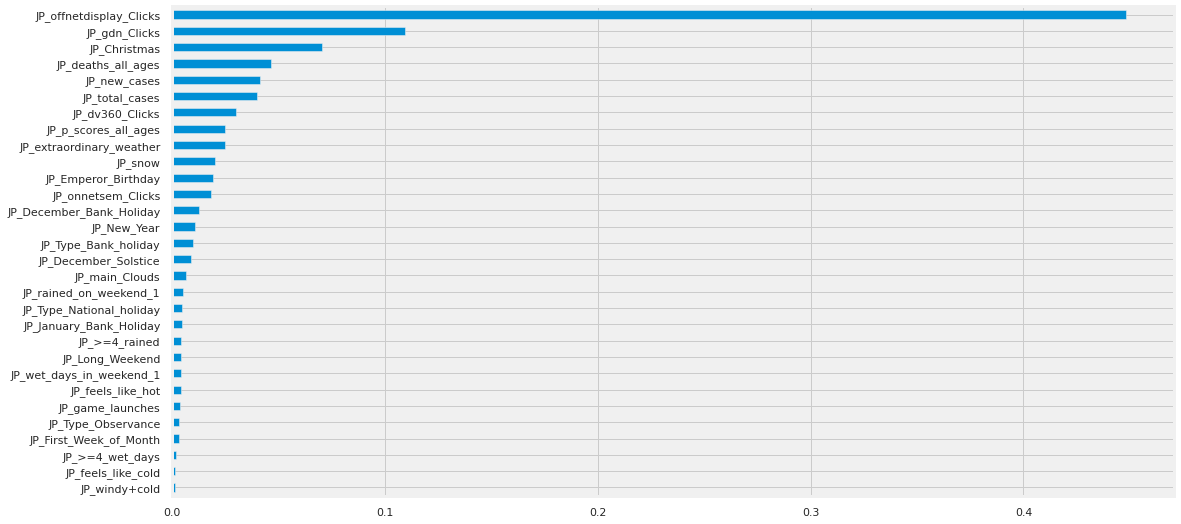

In [68]:
cr_feat_importances_rev = pd.Series(rfr.feature_importances_, index=X_clicks.columns)
cr_feat_importances_rev.nlargest(30).plot(kind='barh').invert_yaxis()

## C. Variance Inflation Factor - Checking for Multicollinearity

### Clicks

In [69]:
# VIF dataframe
vif_data_clicks = pd.DataFrame()
vif_data_clicks["feature"] = X_clicks.columns
  
# calculating VIF for each feature
vif_data_clicks["VIF"] = [variance_inflation_factor(X_clicks.values, i)
                          for i in range(len(X_clicks.columns))]
  
print(vif_data_clicks.sort_values('VIF'))

                      feature        VIF
19           JP_game_launches   1.607496
46      JP_Last_Week_of_Month   1.613583
45     JP_First_Week_of_Month   1.679882
28           JP_Valentine_Day   1.689556
26            JP_Mountain_Day   1.761469
32          JP_Coronation_Day   1.944509
39         JP_deaths_all_ages   2.028704
3          JP_onnetsem_Clicks   2.116224
31        JP_Emperor_Birthday   2.155983
37         JP_Type_Observance   2.189022
2     JP_offnetdisplay_Clicks   2.354286
23             JP_Golden_Week   2.479634
18              JP_windy+cold   2.500114
15              JP_>=4_rained   2.681392
14            JP_>=4_wet_days   2.969842
20               JP_Christmas   3.094372
17     JP_rained_on_weekend_1   3.110956
27                 JP_Sea_Day   3.233993
34              JP_Sports_Day   3.266465
44     JP_Non_Working_Day_>=2   3.367275
16   JP_wet_days_in_weekend_1   3.840258
43            JP_Long_Weekend   4.265510
0             JP_dv360_Clicks   4.486283
35   JP_Type_Nat

### Removing highest VIF feature (along with infinity ones)

In [70]:
vif_data_clicks.replace([np.inf, -np.inf], np.nan, inplace=True)
vif_data_clicks.dropna(inplace=True)
vif_data_clicks = vif_data_clicks.reset_index()

In [71]:
vif_data_clicks = vif_data_clicks.drop(vif_data_clicks.index[23])

In [72]:
X2 = X_clicks[list(vif_data_clicks['feature'].values)]

### Second Iteration

In [73]:
# Second Iteration
X2 = X_clicks[list(vif_data_clicks['feature'].values)]
vif_data_clicks_2 = pd.DataFrame()
vif_data_clicks_2["feature"] = X2.columns
  
# calculating VIF for each feature
vif_data_clicks_2["VIF"] = [variance_inflation_factor(X2.values, i)
                          for i in range(len(X2.columns))]
  
print(vif_data_clicks_2.sort_values('VIF'))

                     feature        VIF
12           JP_Mountain_Day   1.303772
14          JP_Valentine_Day   1.385076
9           JP_game_launches   1.449975
26     JP_Last_Week_of_Month   1.781849
16         JP_Coronation_Day   1.818117
25    JP_First_Week_of_Month   1.827725
15       JP_Emperor_Birthday   1.877167
19        JP_Type_Observance   2.000849
11            JP_Golden_Week   2.130370
10              JP_Christmas   2.342227
13                JP_Sea_Day   2.662028
17             JP_Sports_Day   2.886795
24    JP_Non_Working_Day_>=2   2.893508
4            JP_>=4_wet_days   3.669303
20        JP_deaths_all_ages   3.709211
8              JP_windy+cold   4.015114
23           JP_Long_Weekend   4.291541
22              JP_new_cases   4.385171
18  JP_Type_National_holiday   4.591054
6   JP_wet_days_in_weekend_1   4.827815
5              JP_>=4_rained   4.938374
2    JP_offnetdisplay_Clicks   5.634528
7     JP_rained_on_weekend_1   6.603862
3         JP_onnetsem_Clicks   7.168586


In [74]:
# Dropping last one again!
vif_data_clicks_2 = vif_data_clicks_2.drop(vif_data_clicks_2.index[1])

### Third Iteration

In [75]:
# Third Iteration
X3 = X_clicks[list(vif_data_clicks_2['feature'].values)]
vif_data_clicks_3 = pd.DataFrame()
vif_data_clicks_3["feature"] = X3.columns
  
# calculating VIF for each feature
vif_data_clicks_3["VIF"] = [variance_inflation_factor(X3.values, i)
                          for i in range(len(X3.columns))]
  
print(vif_data_clicks_3.sort_values('VIF'))

                     feature       VIF
11           JP_Mountain_Day  1.300969
13          JP_Valentine_Day  1.384501
8           JP_game_launches  1.429256
25     JP_Last_Week_of_Month  1.780470
15         JP_Coronation_Day  1.818116
24    JP_First_Week_of_Month  1.820565
14       JP_Emperor_Birthday  1.875883
18        JP_Type_Observance  1.989299
10            JP_Golden_Week  2.027633
9               JP_Christmas  2.253784
12                JP_Sea_Day  2.661029
23    JP_Non_Working_Day_>=2  2.855359
16             JP_Sports_Day  2.882539
3            JP_>=4_wet_days  3.566882
19        JP_deaths_all_ages  3.686076
21              JP_new_cases  3.828259
7              JP_windy+cold  4.013646
22           JP_Long_Weekend  4.224148
17  JP_Type_National_holiday  4.488567
5   JP_wet_days_in_weekend_1  4.743742
4              JP_>=4_rained  4.852243
1    JP_offnetdisplay_Clicks  5.121813
6     JP_rained_on_weekend_1  6.563278
2         JP_onnetsem_Clicks  7.162509
20      JP_p_scores_all_a

In [76]:
# Dropiing last one, one more time!
vif_data_clicks_3 = vif_data_clicks_3.drop(vif_data_clicks_3.index[2])

### Fourth Iteration

In [77]:
# Fourth Iteration
X4 = X_clicks[list(vif_data_clicks_3['feature'].values)]
vif_data_clicks_4 = pd.DataFrame()
vif_data_clicks_4["feature"] = X4.columns
  
# calculating VIF for each feature
vif_data_clicks_4["VIF"] = [variance_inflation_factor(X4.values, i)
                          for i in range(len(X4.columns))]
  
print(vif_data_clicks_4.sort_values('VIF').reset_index())

    index                   feature       VIF
0      10           JP_Mountain_Day  1.300808
1      12          JP_Valentine_Day  1.374911
2       7          JP_game_launches  1.420110
3      24     JP_Last_Week_of_Month  1.739354
4      14         JP_Coronation_Day  1.774246
5      23    JP_First_Week_of_Month  1.820491
6      13       JP_Emperor_Birthday  1.868649
7      17        JP_Type_Observance  1.942434
8       9            JP_Golden_Week  2.027612
9       8              JP_Christmas  2.191640
10     11                JP_Sea_Day  2.620492
11     22    JP_Non_Working_Day_>=2  2.839903
12     15             JP_Sports_Day  2.870955
13      2           JP_>=4_wet_days  3.555044
14      6             JP_windy+cold  3.569898
15     18        JP_deaths_all_ages  3.648660
16     20              JP_new_cases  3.787501
17      1   JP_offnetdisplay_Clicks  3.940061
18     21           JP_Long_Weekend  4.221957
19     16  JP_Type_National_holiday  4.487353
20      4  JP_wet_days_in_weekend_

Finally, all the VIFs are less than 10! We can say that these variables have weak or moderate multicollinearity! Let's save them.

Problem is that we have lost **gdn clicks** which is one of the primary response variables! We need to figure out what are the variables that gdn clicks is most correlated with and then remove those. Let's introduce gdn again and see correlation!

In [78]:
final_vif_features = list(vif_data_clicks_4.feature.values)

In [79]:
final_vif_features.append('JP_gdn_Clicks')

In [80]:
X5 = X_clicks[final_vif_features]

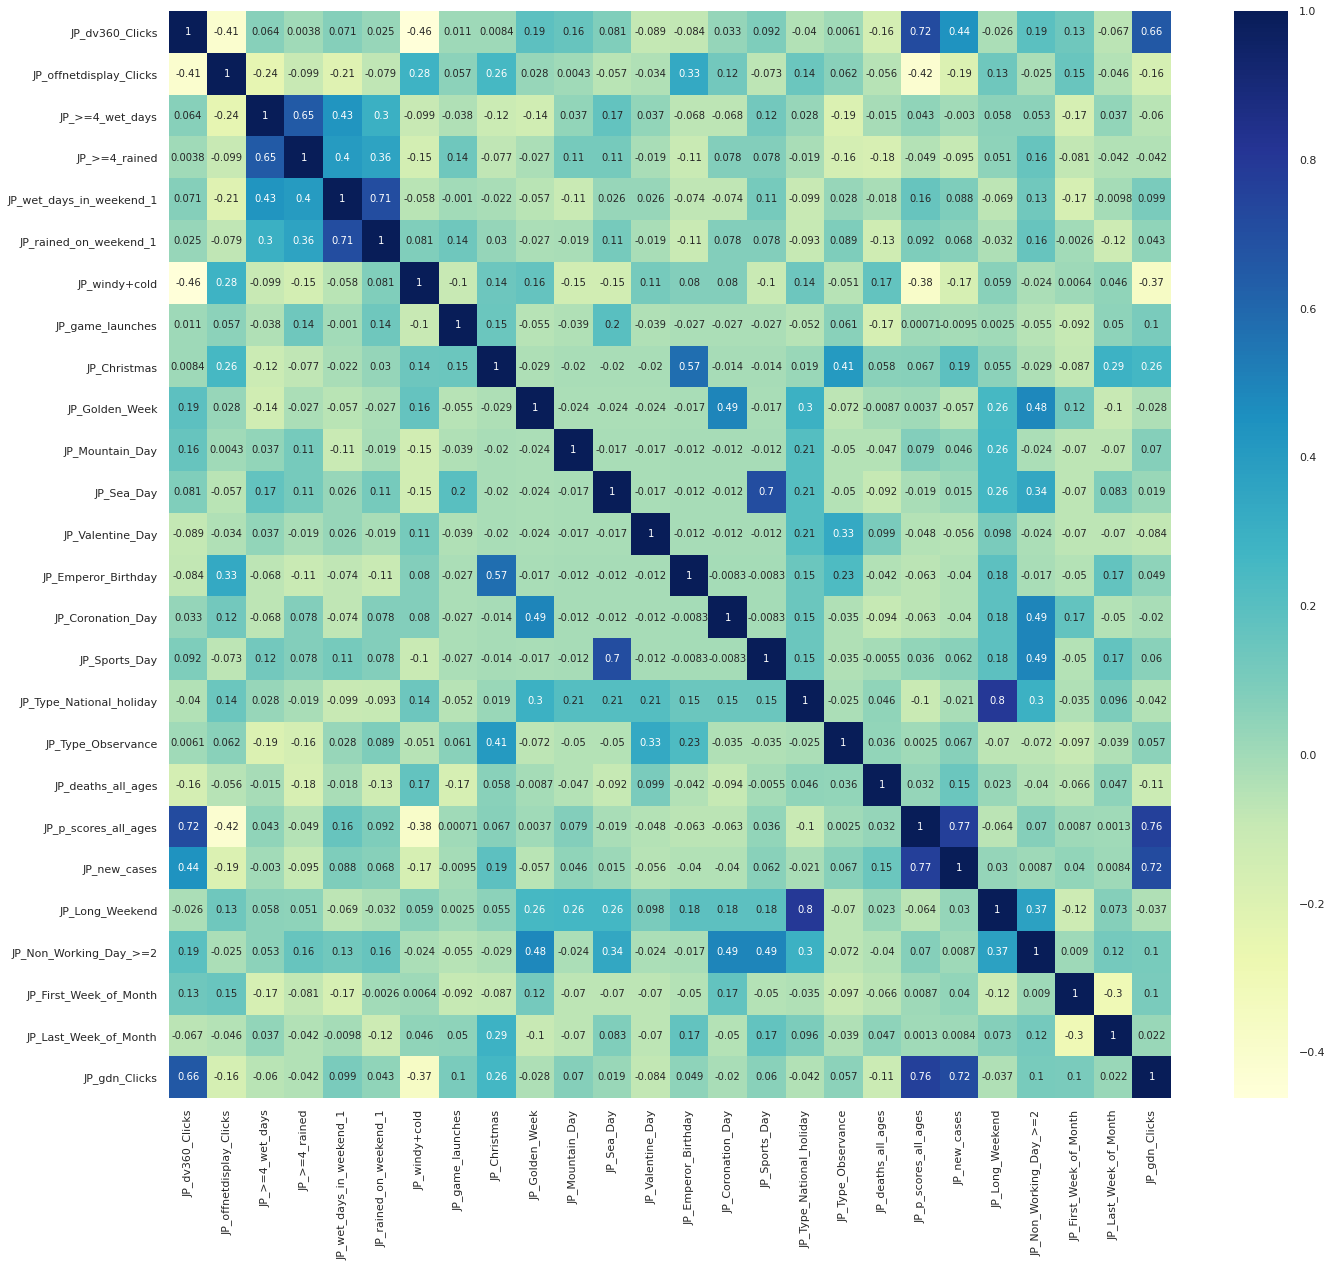

In [81]:
plt.figure(figsize  = (20,20))
sns.heatmap(X5.corr(), annot = True, cmap="YlGnBu")
plt.show()

So, gdn is very strongly corrleated with covid variables - p scores all ages and new case. Let's remove the p score, and run VIF again!

In [82]:
final_vif_features.pop(final_vif_features.index('JP_p_scores_all_ages'))

'JP_p_scores_all_ages'

### Fifth Iteration

In [83]:
# Fifth Iteration
X5 = X_clicks[final_vif_features]
vif_data_clicks_5 = pd.DataFrame()
vif_data_clicks_5["feature"] = X5.columns
  
# calculating VIF for each feature
vif_data_clicks_5["VIF"] = [variance_inflation_factor(X5.values, i)
                          for i in range(len(X5.columns))]
  
print(vif_data_clicks_5.sort_values('VIF').reset_index())

    index                   feature        VIF
0      10           JP_Mountain_Day   1.303622
1      12          JP_Valentine_Day   1.353444
2       7          JP_game_launches   1.441561
3      23     JP_Last_Week_of_Month   1.739840
4      14         JP_Coronation_Day   1.766052
5      22    JP_First_Week_of_Month   1.797429
6      13       JP_Emperor_Birthday   1.820776
7      17        JP_Type_Observance   1.900454
8       9            JP_Golden_Week   2.128232
9       8              JP_Christmas   2.269167
10     11                JP_Sea_Day   2.590004
11     21    JP_Non_Working_Day_>=2   2.870278
12     15             JP_Sports_Day   2.873420
13     19              JP_new_cases   2.875900
14      6             JP_windy+cold   3.434808
15     18        JP_deaths_all_ages   3.649969
16      2           JP_>=4_wet_days   3.653200
17      1   JP_offnetdisplay_Clicks   3.991030
18     20           JP_Long_Weekend   4.281798
19     16  JP_Type_National_holiday   4.579567
20      4  JP

Wow! GDN and DV360 are very strongly correlated!! Let's remove DV360 and see what happens.

In [84]:
final_vif_features.pop(final_vif_features.index('JP_dv360_Clicks'))

'JP_dv360_Clicks'

### Sixth Iteration

In [85]:
# Sixth Iteration
X6 = X_clicks[final_vif_features]
vif_data_clicks_6 = pd.DataFrame()
vif_data_clicks_6["feature"] = X6.columns
  
# calculating VIF for each feature
vif_data_clicks_6["VIF"] = [variance_inflation_factor(X6.values, i)
                          for i in range(len(X6.columns))]
  
print(vif_data_clicks_6.sort_values('VIF').reset_index())

    index                   feature       VIF
0       9           JP_Mountain_Day  1.269445
1      11          JP_Valentine_Day  1.346282
2       6          JP_game_launches  1.440131
3      22     JP_Last_Week_of_Month  1.708216
4      21    JP_First_Week_of_Month  1.741100
5      13         JP_Coronation_Day  1.756983
6      16        JP_Type_Observance  1.811215
7      12       JP_Emperor_Birthday  1.819795
8       8            JP_Golden_Week  1.889365
9       7              JP_Christmas  2.137482
10     10                JP_Sea_Day  2.576006
11     18              JP_new_cases  2.721172
12     20    JP_Non_Working_Day_>=2  2.860064
13     14             JP_Sports_Day  2.873408
14      5             JP_windy+cold  3.433131
15     17        JP_deaths_all_ages  3.463002
16      1           JP_>=4_wet_days  3.512371
17      0   JP_offnetdisplay_Clicks  3.911829
18     19           JP_Long_Weekend  4.265797
19     15  JP_Type_National_holiday  4.542532
20      3  JP_wet_days_in_weekend_

<AxesSubplot: xlabel='feature'>

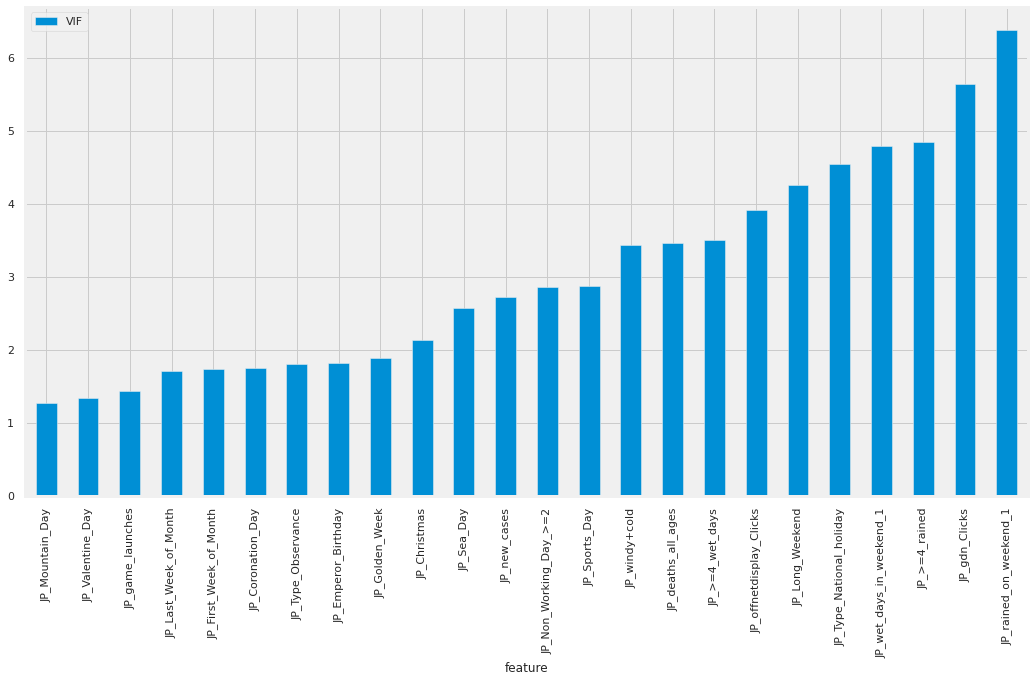

In [86]:
vif_data_clicks_6.sort_values('VIF').plot(kind='bar', x='feature')

### Now it starts to look good. All VIFs are less than 10, mostly less than 5! Which is a sign of weak/moderate multicollinearity. Note that one of the DV/GDN must be dropped to achieve this!

In [87]:
final_vif_features_list= list(vif_data_clicks_6.feature.values)

In [88]:
cr_feat_importances_30 = cr_feat_importances_rev.nlargest(30)

In [89]:
rf_clicks_features_30 = list(cr_feat_importances_30.index)

### Common features between VIF variables and RF variables (first 30)

In [90]:
list(set(final_vif_features_list) & set(rf_clicks_features_30))

['JP_Christmas',
 'JP_>=4_wet_days',
 'JP_new_cases',
 'JP_offnetdisplay_Clicks',
 'JP_windy+cold',
 'JP_deaths_all_ages',
 'JP_Type_Observance',
 'JP_gdn_Clicks',
 'JP_>=4_rained',
 'JP_wet_days_in_weekend_1',
 'JP_game_launches',
 'JP_First_Week_of_Month',
 'JP_Type_National_holiday',
 'JP_Emperor_Birthday',
 'JP_rained_on_weekend_1',
 'JP_Long_Weekend']

Quite interesting set of features! We will make use of this intersection in our analysis later on.

# Modeling - Clicks + Revenue

### Full dataframe for X_Clicks + Y_target_revenue!

In [91]:
df_clicks_revenue = pd.concat([X_clicks, y_target_revenue], axis=1, join='inner')

#### Introducing Lag variables for Hiroshima and Nagasaki Memorial Days

In [92]:
df_clicks_revenue['JP_Nagasaki_Memorial_Day_lag_1'] = df_clicks_revenue['JP_Nagasaki_Memorial_Day'].shift()

In [93]:
df_clicks_revenue['JP_Nagasaki_Memorial_Day_lag_2'] = df_clicks_revenue['JP_Nagasaki_Memorial_Day'].shift(2)

In [94]:
df_clicks_revenue['JP_Hiroshima_Memorial_Day_lag_1'] = df_clicks_revenue['JP_Hiroshima_Memorial_Day'].shift()

In [95]:
df_clicks_revenue['JP_Hiroshima_Memorial_Day_lag_2'] = df_clicks_revenue['JP_Hiroshima_Memorial_Day'].shift(2)

## Creating training and test set based on time

In [142]:
nobs = 24
df_cr_train, df_cr_test = df_clicks_revenue[0:-nobs], df_clicks_revenue[-nobs:]

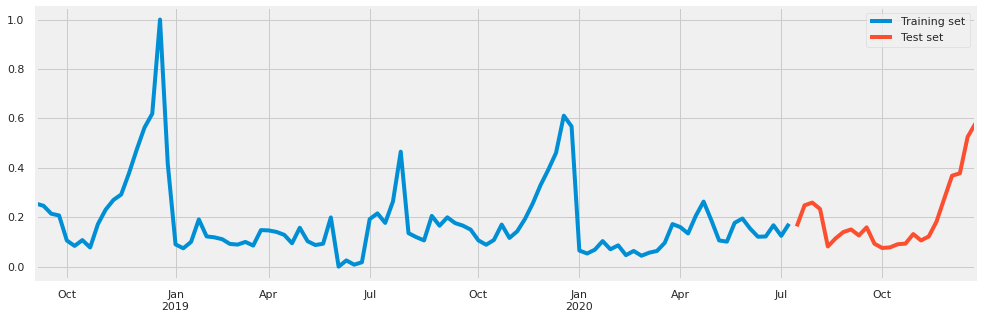

In [301]:
fig, ax = plt.subplots(figsize=(15,5))
df_cr_train['JP_total_npu+rpu_rev_28d_cohort'].plot(ax=ax, xlabel='')
df_cr_test['JP_total_npu+rpu_rev_28d_cohort'].plot(ax=ax, xlabel='')
plt.legend(['Training set', 'Test set'])
plt.show()

### Differencing for training DF

In [102]:
df_cr_differenced = df_cr_train.diff().dropna()
df_cr_differenced_2 = df_cr_differenced.diff().dropna()

### ADF Test - Check stationarity

In [103]:
from statsmodels.tsa.stattools import adfuller

In [104]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [ ]:
# ADF Test on each column
for name, column in df_cr_differenced.iteritems():
    adfuller_test(column, name=column.name)

### Helper function - MAE/MAPE/RMSE

In [106]:
# Define MAE
def mae(y, yhat):
    y = np.asanyarray(y)  # actual
    yhat = np.asanyarray(yhat)  # predicted
    mae_val = np.nanmean(np.abs((y - yhat)))
    return mae_val

In [107]:
# Define MAPE - Divison by zero makes MAPE undefined!
def mape(y, yhat):
    y = np.asanyarray(y)  # actual
    yhat = np.asanyarray(yhat)  # predicted
    mape_val = np.nanmean(np.abs((y - yhat)/y))*100
    return mape_val

In [108]:
def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

## 1. A base model: simple linear regression

In [109]:
y_target_name = 'JP_total_npu+rpu_rev_28d_cohort'

In [110]:
click_features = list(X_clicks.filter(regex='Clicks').columns)

In [111]:
click_features.append(y_target_name)

In [112]:
click_features

['JP_dv360_Clicks',
 'JP_gdn_Clicks',
 'JP_offnetdisplay_Clicks',
 'JP_onnetsem_Clicks',
 'JP_total_npu+rpu_rev_28d_cohort']

In [113]:
df_clicks_base = df[click_features]

In [114]:
pd.notnull(df_clicks_base).value_counts()

JP_dv360_Clicks  JP_gdn_Clicks  JP_offnetdisplay_Clicks  JP_onnetsem_Clicks  JP_total_npu+rpu_rev_28d_cohort
True             True           True                     True                True                               122
dtype: int64

In [115]:
nobs = 24
df_clicks_base_train, df_clicks_base_test = df_clicks_base[0:-nobs], df_clicks_base[-nobs:]

In [116]:
ks = sm.OLS(df_clicks_base_train['JP_total_npu+rpu_rev_28d_cohort'], df_clicks_base_train.drop(['JP_total_npu+rpu_rev_28d_cohort'], axis=1))
ks_res =ks.fit()
ks_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     JP_total_npu+rpu_rev_28d_cohort   R-squared (uncentered):                   0.865
Model:                                         OLS   Adj. R-squared (uncentered):              0.860
Method:                              Least Squares   F-statistic:                              151.0
Date:                             Wed, 15 Mar 2023   Prob (F-statistic):                    4.96e-40
Time:                                     00:07:59   Log-Likelihood:                          99.911
No. Observations:                               98   AIC:                                     -191.8
Df Residuals:                                   94   BIC:                                     -181.5
Df Model:                                        4                                                  
Covariance Type:                         nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
JP_dv360_Clicks            -0.1112      0.055     -2.017      0.047      -0.221      -0.002
JP_gdn_Clicks               0.4956      0.096      5.157      0.000       0.305       0.686
JP_offnetdisplay_Clicks     0.4599      0.054      8.572      0.000       0.353       0.566
JP_onnetsem_Clicks         -0.0597      0.039     -1.533      0.129      -0.137       0.018
==============================================================================
Omnibus:                       44.381   Durbin-Watson:                   0.698
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.650
Skew:                           1.645   Prob(JB):                     2.83e-26
Kurtosis:                       7.242   Cond. No.                         9.13
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

DV360 has a (relatively) large p-value! Interesting. It seems to continue causing troubles.

## 2. Base XGBoost - Clicks only

In [117]:
from xgboost import XGBRegressor

In [118]:
xgb = XGBRegressor(n_estimators=100, max_depth=10, eta=0.2, subsample=0.4, colsample_bytree=1.0)

In [119]:
xgb.fit(df_clicks_base_train.drop([y_target_name], axis=1), df_clicks_base_train[y_target_name])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [120]:
# Model evaluation
print(f"XGB r-squared training {xgb.score(df_clicks_base_train.drop([y_target_name], axis=1),df_clicks_base_train[y_target_name]):.3f}")

XGB r-squared training 1.000


In [121]:
# Model evaluation
print(f"XGB r-squared test {xgb.score(df_clicks_base_test.drop([y_target_name], axis=1),df_clicks_base_test[y_target_name]):.3f}")

XGB r-squared test 0.235


This is cearly a bad overfitting example. We need to optimize hyperparameters!! We can do a grid search, but this Optuna thig looks quite interesting as well.

https://optuna.org/

https://medium.com/subex-ai-labs/efficient-hyperparameter-optimization-for-xgboost-model-using-optuna-3ee9a02566b1

## Using Optuna to find best XGBoost Hyperparameters!

In [123]:
import optuna
from sklearn.metrics import mean_squared_error

In [124]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    # Define model
    model = XGBRegressor(**param)
    
    # Train and test
    X_train = df_clicks_base_train.drop([y_target_name], axis=1)
    y_train = df_clicks_base_train[y_target_name]
    X_test = df_clicks_base_test.drop([y_target_name], axis=1)
    y_test = df_clicks_base_test[y_target_name]
    
    # Fit
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    return mean_squared_error(y_test, y_pred)

In [ ]:
# Create the study
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=100)

In [147]:
print('Best parameters', study.best_params)

Best parameters {'max_depth': 4, 'learning_rate': 0.9131508636605, 'n_estimators': 451, 'min_child_weight': 4, 'gamma': 0.07660351336844093, 'subsample': 0.5975186620728936, 'colsample_bytree': 0.34965908424157427, 'reg_alpha': 0.14901851709203667, 'reg_lambda': 0.881992565918572, 'random_state': 443}


### Build XGBoost model with best set of hyperparameters

In [148]:
# Train and test
X_train = df_clicks_base_train.drop([y_target_name], axis=1)
y_train = df_clicks_base_train[y_target_name]
X_test = df_clicks_base_test.drop([y_target_name], axis=1)
y_test = df_clicks_base_test[y_target_name]

model = XGBRegressor(**study.best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAPE: ', mape(y_test, y_pred))

# Model evaluation
print(f"XGB r-squared training {model.score(X_train,y_train):.3f}")
print(f"XGB r-squared test {model.score(X_test,y_test):.3f}")

MSE:  0.010360970444380951
RMSE:  0.1017888522598666
MAPE:  34.609057006131174
XGB r-squared training 0.739
XGB r-squared test 0.438


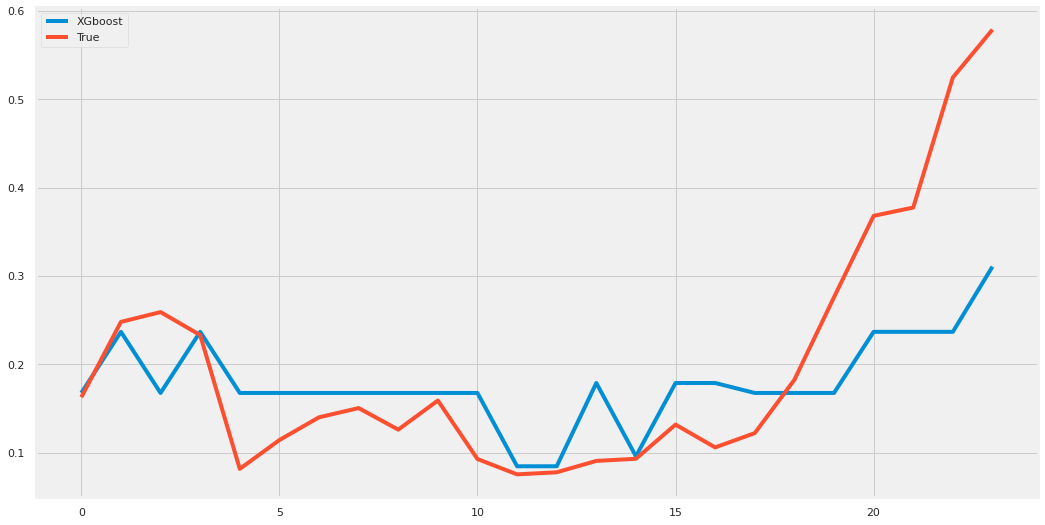

In [149]:
plt.plot(y_pred)
plt.plot(y_test.values)
plt.legend(['XGboost', 'True'])

# SARIMAX

### Auto ARIMA Grid Search - For target variable only

### m=52

In [ ]:
from pmdarima import auto_arima
stepwise_fit_revenue = auto_arima(df[y_target_name], start_p=0, start_q=0,
                                  max_p=5, max_q=5, m=52,
                                  seasonal=True,
                                  d=0,                     # the order of first-differencing
                                  trace=True,              # whether to print status on the fits
                                  error_action='ignore',   # we don't want to know if an order does not work
                                  suppress_warnings=True,  # we don't want convergence warnings
                                  stepwise=True)           # set to stepwise

### m=13

In [ ]:
stepwise_fit_revenue = auto_arima(df[y_target_name], start_p=0, start_q=0,
                                  max_p=5, max_q=5, m=13,
                                  seasonal=True,
                                  d=0,                     # the order of first-differencing
                                  trace=True,              # whether to print status on the fits
                                  error_action='ignore',   # we don't want to know if an order does not work
                                  suppress_warnings=True,  # we don't want convergence warnings
                                  stepwise=True)           # set to stepwise

### m=26

In [ ]:
stepwise_fit_revenue = auto_arima(df[y_target_name], start_p=0, start_q=0,
                                  max_p=5, max_q=5, m=26,
                                  seasonal=True,
                                  d=0,                     # the order of first-differencing
                                  trace=True,              # whether to print status on the fits
                                  error_action='ignore',   # we don't want to know if an order does not work
                                  suppress_warnings=True,  # we don't want convergence warnings
                                  stepwise=True)           # set to stepwise

### m=4

In [ ]:
stepwise_fit_revenue = auto_arima(df[y_target_name], start_p=0, start_q=0,
                                  max_p=5, max_q=5, m=4,
                                  seasonal=True,
                                  d=0,                     # the order of first-differencing
                                  trace=True,              # whether to print status on the fits
                                  error_action='ignore',   # we don't want to know if an order does not work
                                  suppress_warnings=True,  # we don't want convergence warnings
                                  stepwise=True)           # set to stepwise

Using these values (p,d,q)(P,D,Q,S) we will build SARIMAX models incrmentally using RF feature importance. We will start with a single featur and then add one feature at a time till a given number (say 30). The best model from this approach will be chosen the one with the lowest AIC!

## Automate Step wise SARIMAX with RF Feature Importance

In [143]:
def build_incremental_sarimax_with_rf_importance(method, rf_features_list, order, seasonal_order):
    
    '''
    Add one feature at a time, on the basis of Random Forest Feature importance
    And build Sariamax!
    '''

    Y_train, Y_test = df_cr_train[y_target_name], df_cr_test[y_target_name]
    
    n_features = len(rf_features_list)
    
    all_aic = []
    all_training_mae = []
    all_test_mae = []
    all_test_mape = []
    
    all_features = {}
    all_results = {}
    
    for i in range(n_features):
        current_features = rf_features_list[:i+1]
        print(i, '. Building SARIMAX for features:', current_features)
        
        # Create training and test set
        X_train, X_test = df_cr_train[current_features], df_cr_test[current_features]
    
        # Build Model
        sarimax = sm.tsa.SARIMAX(Y_train,\
                                exog=X_train,\
                                order=order,\
                                seasonal_order=seasonal_order,\
                                enforce_invertibility=False)

        res = sarimax.fit(method=method)
        all_aic.append(res.aic)
        all_training_mae.append(res.mae)
        all_results[i+1] = res.summary()
        all_features[i+1] = current_features
        
        # Prediction on test
        test_predict = res.predict(start=X_test.index[0], end=X_test.index[nobs-1], exog=X_test)
        
        all_test_mae.append(mae(Y_test.values, test_predict.values))
        all_test_mape.append(mape(Y_test.values, test_predict.values))

    return all_features, all_results, all_aic, all_training_mae, all_test_mae, all_test_mape

In [140]:
#all_features, all_results, all_aic, all_training_mae, all_test_mae, all_test_mape = build_incremental_sarimax_with_rf_importance('bfgs', rf_clicks_features_30[:10], (1,0,0), (1,0,1,52))

### (1,0,0), (1,0,1,52)

Note the use of Nedler-Mead optimization algorithm, as LBFGS has convergence issues!

In [ ]:
all_features, all_results, all_aic, all_training_mae, all_test_mae, all_test_mape = build_incremental_sarimax_with_rf_importance('nm', rf_clicks_features_30, (1,0,0), (1,0,1,52))

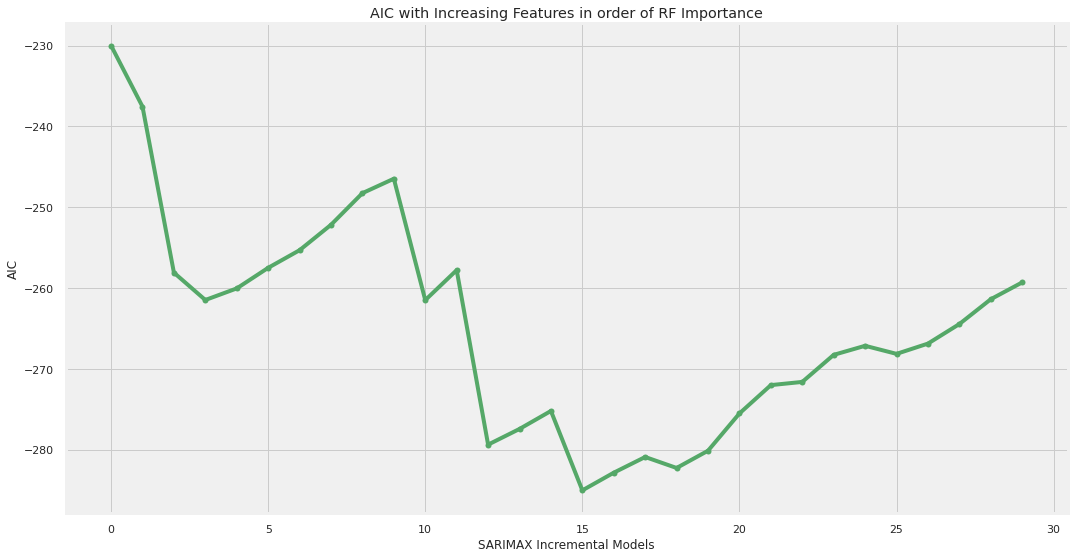

In [145]:
plt.plot(all_aic, 'o-g')
# set axis titles
plt.ylabel("AIC")
plt.xlabel("SARIMAX Incremental Models")
# set chart title
plt.title("AIC with Increasing Features in order of RF Importance")
plt.show()

Both cases gice same set of best features!!

In [150]:
min_train_index = all_training_mae.index(min(all_training_mae))
min_test_index = all_test_mae.index(min(all_test_mae))

In [151]:
best_training_features = all_features[min_train_index+1]
best_test_features = all_features[min_test_index+1]

In [152]:
best_aic_index = all_aic.index(min(all_aic))

In [153]:
best_aic_index

15

In [154]:
all_aic[best_aic_index]

-285.0430613892073

In [155]:
best_aic_features = all_features[16]

In [156]:
best_aic_features

['JP_offnetdisplay_Clicks',
 'JP_gdn_Clicks',
 'JP_Christmas',
 'JP_deaths_all_ages',
 'JP_new_cases',
 'JP_total_cases',
 'JP_dv360_Clicks',
 'JP_p_scores_all_ages',
 'JP_extraordinary_weather',
 'JP_snow',
 'JP_Emperor_Birthday',
 'JP_onnetsem_Clicks',
 'JP_December_Bank_Holiday',
 'JP_New_Year',
 'JP_Type_Bank_holiday',
 'JP_December_Solstice']

In [157]:
all_results[16]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:      JP_total_npu+rpu_rev_28d_cohort   No. Observations:                   98
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 52)   Log Likelihood                 162.522
Date:                              Wed, 15 Mar 2023   AIC                           -285.043
Time:                                      00:17:20   BIC                           -233.344
Sample:                                  09-03-2018   HQIC                          -264.132
                                       - 07-13-2020                                         
Covariance Type:                                opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
JP_offnetdisplay_Clicks      0.3688      0.054      6.778      0.000       0.262       0.475
JP_gdn_Clicks                0.3224      0.135      2.395      0.017       0.059       0.586
JP_Christmas                 0.2843      0.085      3.358      0.001       0.118       0.450
JP_deaths_all_ages          -0.0393      0.032     -1.212      0.226      -0.103       0.024
JP_new_cases              2.655e-05   4.72e-05      0.563      0.573   -6.59e-05       0.000
JP_total_cases           -2.718e-07   1.29e-06     -0.210      0.833    -2.8e-06    2.26e-06
JP_dv360_Clicks              0.0128      0.069      0.186      0.853      -0.122       0.147
JP_p_scores_all_ages        -0.0676      0.317     -0.214      0.831      -0.688       0.553
JP_extraordinary_weather    -0.0025      0.100     -0.025      0.980      -0.198       0.193
JP_snow                      0.0029      0.104      0.028      0.977      -0.201       0.207
JP_Emperor_Birthday          0.2368      0.064      3.687      0.000       0.111       0.363
JP_onnetsem_Clicks          -0.0221      0.056     -0.396      0.692      -0.131       0.087
JP_December_Bank_Holiday     0.0755      0.012      6.052      0.000       0.051       0.100
JP_New_Year                  0.0756      0.012      6.064      0.000       0.051       0.100
JP_Type_Bank_holiday         0.0757      0.012      6.072      0.000       0.051       0.100
JP_December_Solstice         0.1700      0.035      4.916      0.000       0.102       0.238
ar.L1                        0.5267      0.081      6.477      0.000       0.367       0.686
ar.S.L52                 -5.196e-05      0.072     -0.001      0.999      -0.142       0.142
ma.S.L52                     0.0002      0.072      0.002      0.998      -0.142       0.142
sigma2                       0.0022      0.000      5.842      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                13.28
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.66
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.24e+18. Standard errors may be unstable.
"""

## Correlation between best training features

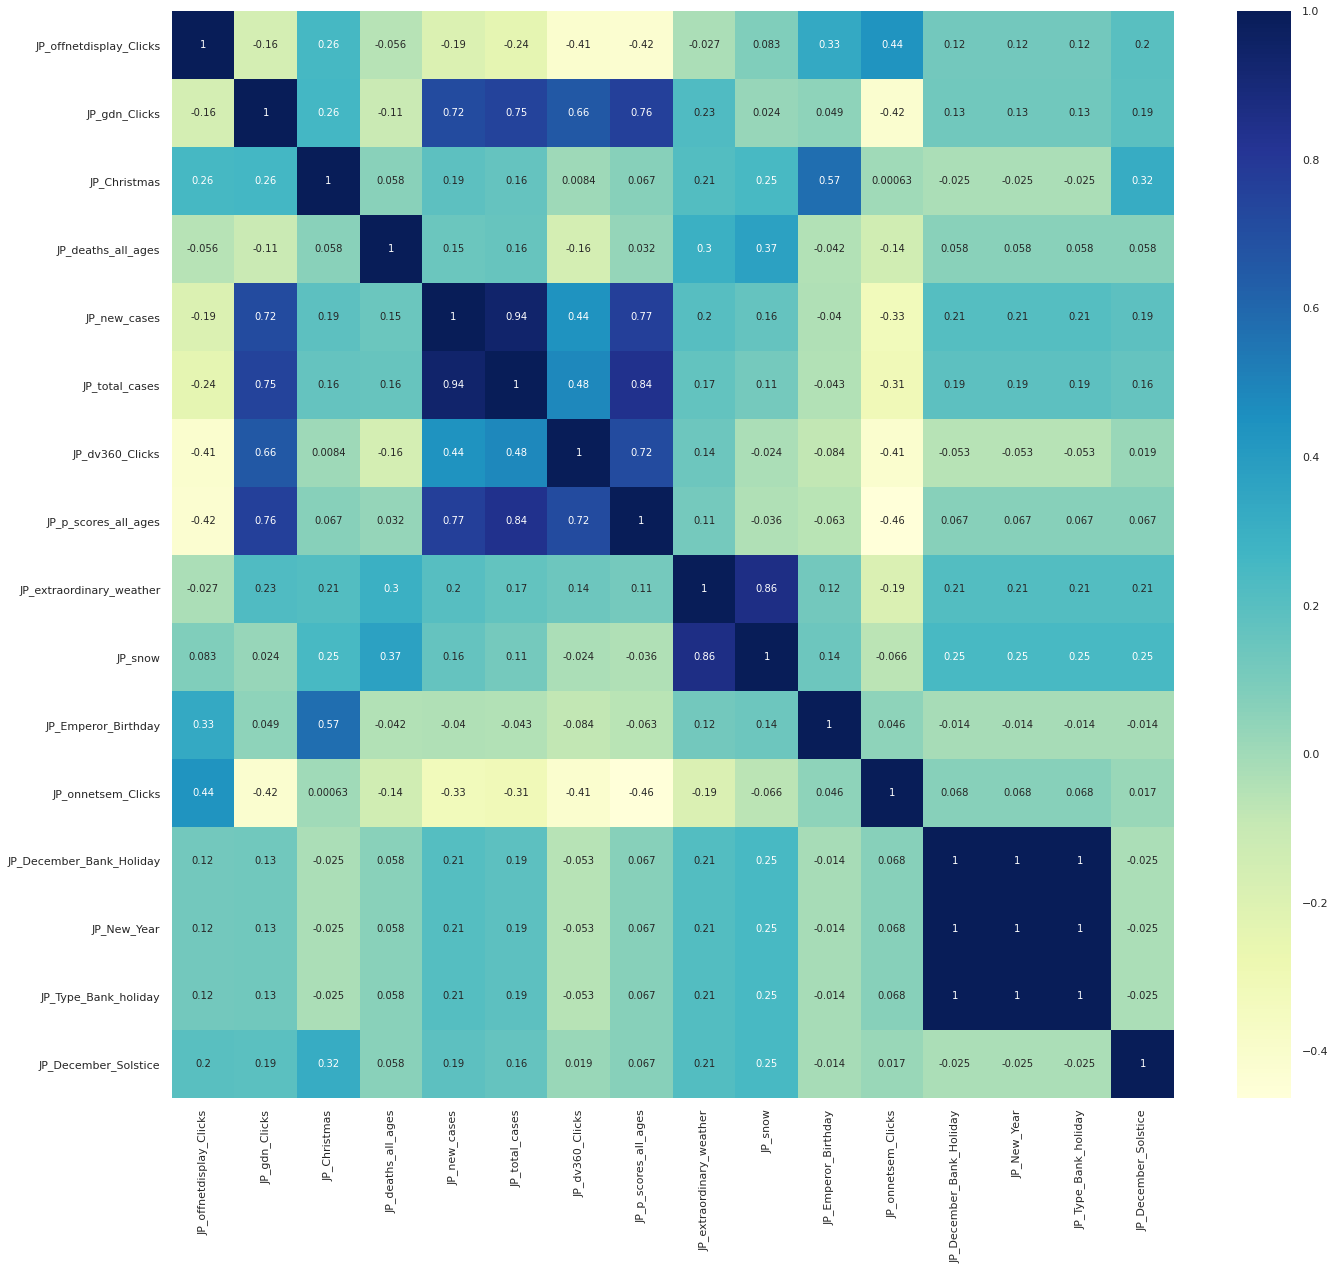

In [158]:
plt.figure(figsize  = (20,20))
sns.heatmap(df[best_aic_features].corr(), annot = True, cmap="YlGnBu")
plt.show()

## Manually curating the features from the best training features

There are lots of redundant features here, which we know by domain knowledge/intuition and which is also confirmed by looking at correlation heatmap! Let's remove some of them and create a new list of features.

Before that,  let's evaluate the best rf model on test set anyway!

### Best RF Model

In [159]:
sarimax_best_rf = sm.tsa.SARIMAX(df_cr_train[y_target_name],\
                                exog=df_cr_train[best_aic_features],\
                                order=(1,0,0),\
                                seasonal_order=(1,0,1,52),\
                                enforce_invertibility=False)

sarimax_best_rf_res = sarimax_best_rf.fit(method='nm', maxiter=200)
sarimax_best_rf_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:      JP_total_npu+rpu_rev_28d_cohort   No. Observations:                   98
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 52)   Log Likelihood                 166.296
Date:                              Wed, 15 Mar 2023   AIC                           -292.593
Time:                                      00:23:58   BIC                           -240.894
Sample:                                  09-03-2018   HQIC                          -271.682
                                       - 07-13-2020                                         
Covariance Type:                                opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
JP_offnetdisplay_Clicks      0.4023      0.048      8.373      0.000       0.308       0.496
JP_gdn_Clicks                0.2762      0.122      2.269      0.023       0.038       0.515
JP_Christmas                 0.1855      0.075      2.481      0.013       0.039       0.332
JP_deaths_all_ages          -0.0385      0.027     -1.430      0.153      -0.091       0.014
JP_new_cases              2.794e-05   3.72e-05      0.751      0.453    -4.5e-05       0.000
JP_total_cases           -2.237e-07   1.29e-06     -0.174      0.862   -2.74e-06     2.3e-06
JP_dv360_Clicks              0.0128      0.065      0.196      0.844      -0.115       0.140
JP_p_scores_all_ages        -0.0767      0.313     -0.245      0.806      -0.689       0.536
JP_extraordinary_weather    -0.0027      0.077     -0.035      0.972      -0.154       0.149
JP_snow                      0.0026      0.080      0.032      0.974      -0.155       0.160
JP_Emperor_Birthday          0.2999      0.047      6.315      0.000       0.207       0.393
JP_onnetsem_Clicks          -0.0223      0.056     -0.399      0.690      -0.132       0.087
JP_December_Bank_Holiday     0.0613      0.013      4.898      0.000       0.037       0.086
JP_New_Year                  0.0754      0.013      6.029      0.000       0.051       0.100
JP_Type_Bank_holiday         0.0611      0.013      4.887      0.000       0.037       0.086
JP_December_Solstice         0.1016      0.071      1.426      0.154      -0.038       0.241
ar.L1                        0.6776      0.066     10.195      0.000       0.547       0.808
ar.S.L52                    -0.0007      0.078     -0.009      0.993      -0.154       0.152
ma.S.L52                     0.0008      0.078      0.011      0.991      -0.152       0.154
sigma2                       0.0020      0.000      6.639      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.02
Prob(Q):                              0.91   Prob(JB):                         0.13
Heteroskedasticity (H):               0.68   Skew:                             0.10
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+19. Standard errors may be unstable.
"""

In [160]:
y_test = df_cr_test['JP_total_npu+rpu_rev_28d_cohort']
test_predict = sarimax_best_rf_res.predict(start=df_cr_test.index[0], end=df_cr_test.index[nobs-1], exog=df_cr_test[best_aic_features])

print(f"SARIMAX training MAE {sarimax_best_rf_res.mae:.3f}")
print(f"SARIMAX test MAE {mae(y_test.values, test_predict.values):.3f}")
print(f"SARIMAX test MAPE {mape(y_test.values, test_predict.values):.3f}")

SARIMAX training MAE 0.033
SARIMAX test MAE 0.113
SARIMAX test MAPE 71.753


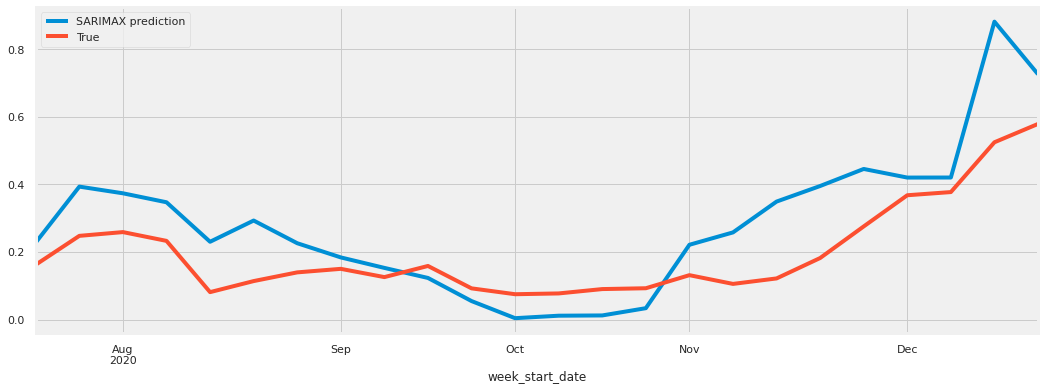

In [167]:
# Forecast plot
fig, ax = plt.subplots(figsize=(16,6))
sarimax_best_rf_res.predict(ax=ax, start=df_cr_test.index[0], end=df_cr_test.index[nobs-1], exog=df_cr_test[best_aic_features]).plot(legend=False)
df_cr_test['JP_total_npu+rpu_rev_28d_cohort'].plot(ax=ax, legend=False)
plt.legend(['SARIMAX prediction', 'True'])
plt.show()

### Removing redundant features, adding more weather, weekly, Nagasaki Memorial Day

In [168]:
curated_features = ['JP_offnetdisplay_Clicks',
 'JP_gdn_Clicks',
 'JP_dv360_Clicks',
 'JP_onnetsem_Clicks',
 'JP_Christmas',
 'JP_Emperor_Birthday',
 'JP_January_Bank_Holiday',
 'JP_December_Solstice',
 'JP_deaths_all_ages',
 'JP_new_cases',
 'JP_snow',
 'JP_rained_on_weekend_1',
 'JP_>=4_rained',
 'JP_main_Clouds',
 'JP_First_Week_of_Month',
 'JP_Last_Week_of_Month',
 'JP_Long_Weekend',
 'JP_Nagasaki_Memorial_Day']

Rained on weekend / wet days in weekend seem redundant. Same for >=4 rained and wet days. Let's see!

In [169]:
df_cr_train = df_cr_train.fillna(0.)

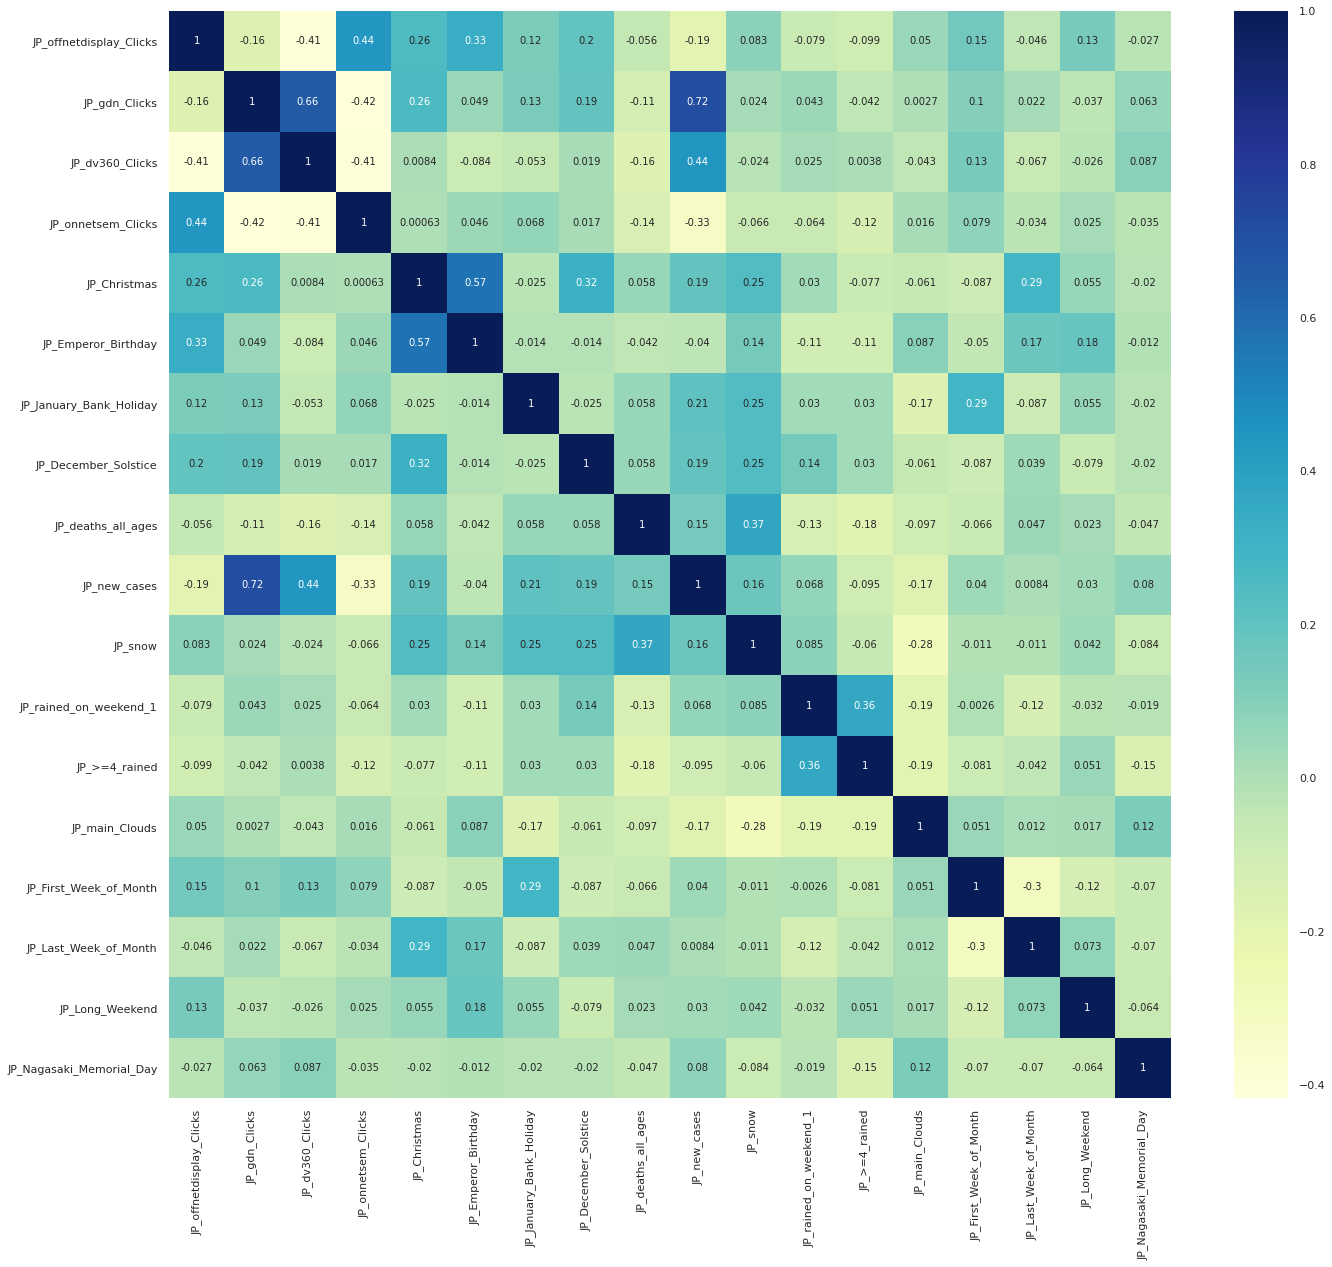

In [170]:
plt.figure(figsize  = (20,20))
sns.heatmap(df[curated_features].corr(), annot = True, cmap="YlGnBu")
plt.show()

This starts to look good. Let's build a SARIMAX model!

In [171]:
sarimax_curated = sm.tsa.SARIMAX(df_cr_train['JP_total_npu+rpu_rev_28d_cohort'],\
                                exog=df_cr_train[curated_features],\
                                order=(1,0,0),\
                                seasonal_order=(1,0,1,52),\
                                enforce_invertibility=False)

sarimax_curated_res = sarimax_curated.fit(method='nm', maxiter=200)
sarimax_curated_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:      JP_total_npu+rpu_rev_28d_cohort   No. Observations:                   98
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 52)   Log Likelihood                 169.743
Date:                              Wed, 15 Mar 2023   AIC                           -295.485
Time:                                      00:30:31   BIC                           -238.616
Sample:                                  09-03-2018   HQIC                          -272.483
                                       - 07-13-2020                                         
Covariance Type:                                opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
JP_offnetdisplay_Clicks      0.4073      0.048      8.511      0.000       0.313       0.501
JP_gdn_Clicks                0.2309      0.129      1.789      0.074      -0.022       0.484
JP_dv360_Clicks              0.0187      0.062      0.304      0.761      -0.102       0.140
JP_onnetsem_Clicks          -0.0059      0.052     -0.113      0.910      -0.108       0.096
JP_Christmas                 0.2469      0.088      2.821      0.005       0.075       0.418
JP_Emperor_Birthday          0.2734      0.066      4.171      0.000       0.145       0.402
JP_January_Bank_Holiday      0.2488      0.040      6.296      0.000       0.171       0.326
JP_December_Solstice         0.1276      0.073      1.737      0.082      -0.016       0.272
JP_deaths_all_ages          -0.0241      0.030     -0.798      0.425      -0.083       0.035
JP_new_cases              1.764e-05   2.51e-05      0.702      0.482   -3.16e-05    6.69e-05
JP_snow                     -0.0011      0.019     -0.058      0.954      -0.038       0.035
JP_rained_on_weekend_1       0.0014      0.010      0.142      0.887      -0.018       0.021
JP_>=4_rained               -0.0071      0.013     -0.561      0.575      -0.032       0.018
JP_main_Clouds               0.0030      0.013      0.237      0.813      -0.022       0.028
JP_First_Week_of_Month      -0.0174      0.011     -1.532      0.125      -0.040       0.005
JP_Last_Week_of_Month       -0.0098      0.012     -0.799      0.424      -0.034       0.014
JP_Long_Weekend             -0.0227      0.016     -1.444      0.149      -0.053       0.008
JP_Nagasaki_Memorial_Day    -0.0479      0.040     -1.191      0.234      -0.127       0.031
ar.L1                        0.5868      0.114      5.138      0.000       0.363       0.811
ar.S.L52                 -5.431e-05      0.075     -0.001      0.999      -0.148       0.148
ma.S.L52                     0.0004      0.075      0.006      0.995      -0.147       0.148
sigma2                       0.0019      0.000      4.604      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   1.19   Jarque-Bera (JB):                 9.20
Prob(Q):                              0.27   Prob(JB):                         0.01
Heteroskedasticity (H):               0.57   Skew:                             0.41
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.62e+16. Standard errors may be unstable.
"""

In [172]:
y_test = df_cr_test['JP_total_npu+rpu_rev_28d_cohort']
test_predict = sarimax_curated_res.predict(start=df_cr_test.index[0], end=df_cr_test.index[23], exog=df_cr_test[curated_features])

print(f"SARIMAX training MAE {sarimax_curated_res.mae:.3f}")
print(f"SARIMAX test MAE {mae(y_test.values, test_predict.values):.3f}")
print(f"SARIMAX test MAPE {mape(y_test.values, test_predict.values):.3f}")

SARIMAX training MAE 0.032
SARIMAX test MAE 0.186
SARIMAX test MAPE 114.692


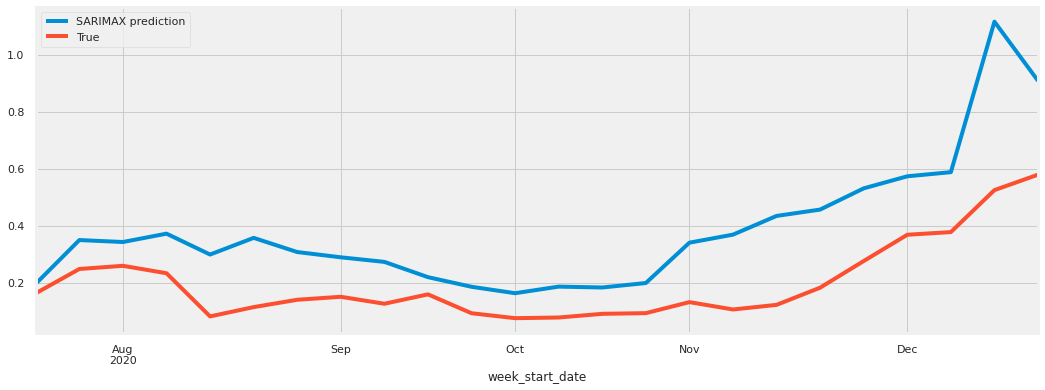

In [174]:
# Forecast plot
fig, ax = plt.subplots(figsize=(16,6))
sarimax_curated_res.predict(ax=ax, start=df_cr_test.index[0], end=df_cr_test.index[nobs-1], exog=df_cr_test[curated_features]).plot(legend=False)
df_cr_test['JP_total_npu+rpu_rev_28d_cohort'].plot(ax=ax, legend=False)
plt.legend(['SARIMAX prediction', 'True'])
plt.show()

### Exploring weights within features:Last_Week_of_Month

#### Adding Last week of every month dummy!

In [175]:
n_rows = df_clicks_revenue.shape[0]

In [176]:
all_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',\
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [177]:
for month in all_months:
    df_clicks_revenue['Last_Week_of_' + month] = np.zeros(n_rows)

In [178]:
# Year/Month/Month-Year
df_clicks_revenue['year'] = df_clicks_revenue.index.year.values
df_clicks_revenue['month'] = df_clicks_revenue.index.month.values
#df_clicks_revenue['month-year'] = df_clicks_revenue.index.to_period('M').strftime('%Y-%m').values

In [179]:
#df_clicks_revenue.to_csv('test_last_week_data.csv')

In [180]:
df_clicks_revenue_new = pd.read_csv('test_last_week_data.csv')

In [181]:
for month in all_months:
    df_clicks_revenue['Last_Week_of_' + month] = df_clicks_revenue_new['Last_Week_of_' + month].values

Note that we are overwriting variables names, for the full dataframe as well as train/test!

In [182]:
nobs = 24
df_cr_train, df_cr_test = df_clicks_revenue[0:-nobs], df_clicks_revenue[-nobs:]

### RF Feature importance once again - after addition of new variables!

In [183]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(df_clicks_revenue.drop(['month', y_target_name], axis=1).fillna(0), y_target_revenue)

RandomForestRegressor(random_state=42)

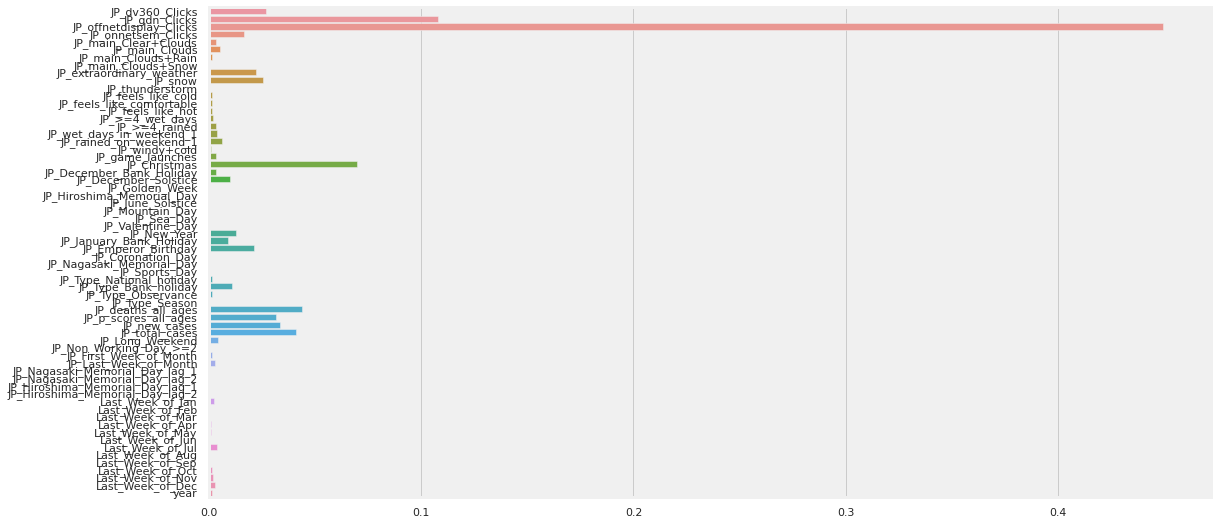

In [184]:
sns.barplot(x=rfr.feature_importances_, y=df_clicks_revenue.drop(['month', y_target_name], axis=1).columns, orient='h');

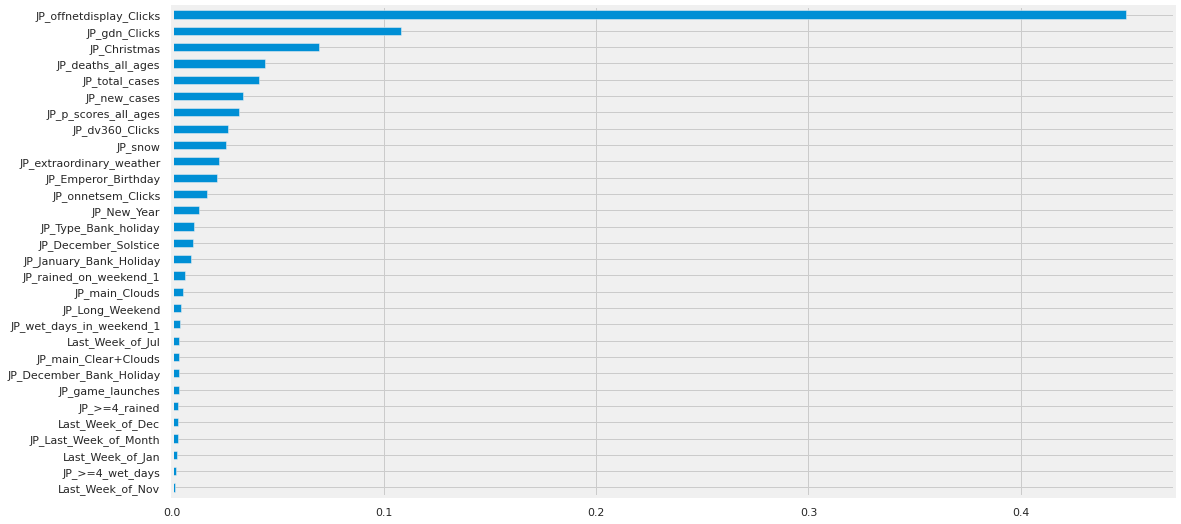

In [185]:
new_rf_importance = pd.Series(rfr.feature_importances_, index=df_clicks_revenue.drop(['month', y_target_name], axis=1).columns)
new_rf_importance.nlargest(30).plot(kind='barh').invert_yaxis()

### 30 most important features according to Random Forest!

In [186]:
rf_30 = list(new_rf_importance.nlargest(30).index)

In [ ]:
all_features, all_results, all_aic, all_training_mae, all_test_mae, all_test_mape = build_incremental_sarimax_with_rf_importance('nm', rf_30, (1,0,0), (1,0,1,52))

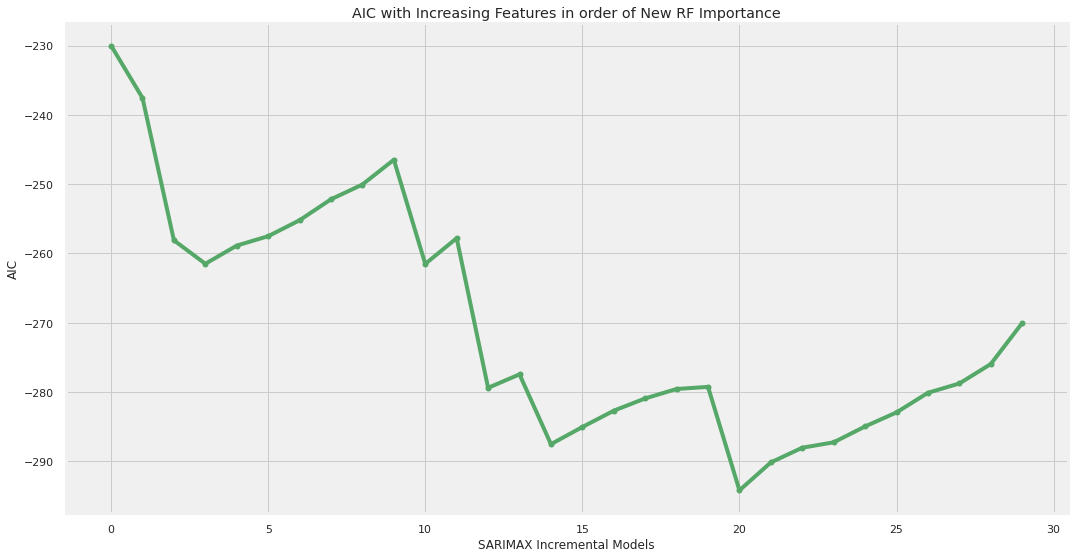

In [188]:
plt.plot(all_aic, 'o-g')
# set axis titles
plt.ylabel("AIC")
plt.xlabel("SARIMAX Incremental Models")
# set chart title
plt.title("AIC with Increasing Features in order of New RF Importance")
plt.show()

In [189]:
all_aic[21]

-290.1482488668588

In [307]:
curated_new = ['JP_offnetdisplay_Clicks',
 'JP_gdn_Clicks',
 'JP_dv360_Clicks',
 'JP_Christmas',
 'JP_Emperor_Birthday',
 'JP_January_Bank_Holiday',
 'JP_December_Solstice',
 'JP_snow',
 'Last_Week_of_Jul',
 'JP_Long_Weekend',
 'JP_Nagasaki_Memorial_Day']

In [308]:
sarimax_curated = sm.tsa.SARIMAX(df_cr_train['JP_total_npu+rpu_rev_28d_cohort'],\
                                exog=df_cr_train[curated_new],\
                                order=(1,0,0),\
                                seasonal_order=(1,0,1,52),\
                                enforce_invertibility=False)

sarimax_curated_res = sarimax_curated.fit(method='nm', maxiter=200)
sarimax_curated_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:      JP_total_npu+rpu_rev_28d_cohort   No. Observations:                   98
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 52)   Log Likelihood                 177.608
Date:                              Wed, 15 Mar 2023   AIC                           -325.216
Time:                                      04:47:18   BIC                           -286.442
Sample:                                  09-03-2018   HQIC                          -309.533
                                       - 07-13-2020                                         
Covariance Type:                                opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
JP_offnetdisplay_Clicks      0.3419      0.045      7.643      0.000       0.254       0.430
JP_gdn_Clicks                0.2434      0.113      2.156      0.031       0.022       0.465
JP_dv360_Clicks              0.0165      0.052      0.318      0.751      -0.085       0.118
JP_Christmas                 0.2188      0.054      4.016      0.000       0.112       0.326
JP_Emperor_Birthday          0.3462      0.042      8.250      0.000       0.264       0.428
JP_January_Bank_Holiday      0.2280      0.025      9.055      0.000       0.179       0.277
JP_December_Solstice         0.1255      0.039      3.249      0.001       0.050       0.201
JP_snow                     -0.0124      0.011     -1.173      0.241      -0.033       0.008
Last_Week_of_Jul             0.1400      0.077      1.829      0.067      -0.010       0.290
JP_Long_Weekend             -0.0143      0.012     -1.231      0.218      -0.037       0.008
JP_Nagasaki_Memorial_Day    -0.0241      0.056     -0.428      0.669      -0.134       0.086
ar.L1                        0.7009      0.068     10.323      0.000       0.568       0.834
ar.S.L52                    -0.0010      0.052     -0.020      0.984      -0.104       0.102
ma.S.L52                     0.0024      0.052      0.046      0.963      -0.100       0.105
sigma2                       0.0015      0.000      6.451      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   2.80   Jarque-Bera (JB):                 8.54
Prob(Q):                              0.09   Prob(JB):                         0.01
Heteroskedasticity (H):               0.64   Skew:                             0.53
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.39e+16. Standard errors may be unstable.
"""

In [309]:
y_test = df_cr_test['JP_total_npu+rpu_rev_28d_cohort']
test_predict = sarimax_curated_res.predict(start=df_cr_test.index[0], end=df_cr_test.index[23], exog=df_cr_test[curated_new])

print(f"SARIMAX training MAE {sarimax_curated_res.mae:.3f}")
print(f"SARIMAX test MAE {mae(y_test.values, test_predict.values):.3f}")
print(f"SARIMAX test MAPE {mape(y_test.values, test_predict.values):.3f}")

SARIMAX training MAE 0.029
SARIMAX test MAE 0.078
SARIMAX test MAPE 52.295


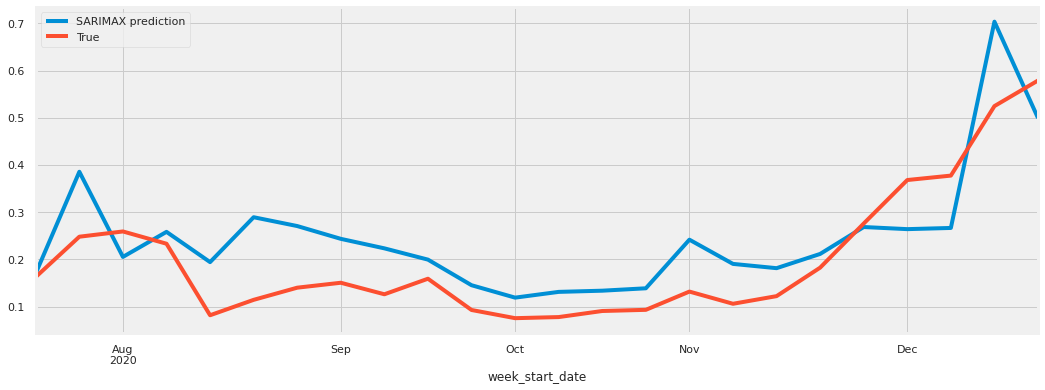

In [310]:
# Forecast plot
fig, ax = plt.subplots(figsize=(16,6))
sarimax_curated_res.predict(ax=ax, start=df_cr_test.index[0], end=df_cr_test.index[nobs-1], exog=df_cr_test[curated_new]).plot(legend=False)
df_cr_test['JP_total_npu+rpu_rev_28d_cohort'].plot(ax=ax, legend=False)
plt.legend(['SARIMAX prediction', 'True'])
plt.show()

## Assigning Weights to (Internal) Features

It would make more sense to give more weightage to moe important variables (for eample, if gdn is more important than other channels, it should probably get more weight)

In [236]:
def build_weighted_sarimax(features, weights):
    
    '''
    '''
    
    # Stupid sanity check! Duh.
    assert len(features) == len(weights)
    
    # Build
    sarimax_curated = sm.tsa.SARIMAX(df_cr_train['JP_total_npu+rpu_rev_28d_cohort'],\
                                exog=df_cr_train[features]*weights,\
                                order=(1,0,0),\
                                seasonal_order=(1,0,1,52),\
                                enforce_invertibility=False)

    sarimax_curated_res = sarimax_curated.fit(method='nm', maxiter=200)
    print(sarimax_curated_res.summary())
    
    y_test = df_cr_test['JP_total_npu+rpu_rev_28d_cohort']
    test_predict = sarimax_curated_res.predict(start=df_cr_test.index[0], end=df_cr_test.index[nobs-1],\
                                               exog=df_cr_test[features])
    
    print(f"SARIMAX training MAE {sarimax_curated_res.mae:.3f}")
    print(f"SARIMAX test MAE {mae(y_test.values, test_predict.values):.3f}")
    print(f"SARIMAX test MSE {mean_squared_error(y_test.values, test_predict.values):.3f}")
    print(f"SARIMAX test MAPE {mape(y_test.values, test_predict.values):.3f}")
    print(f"SARIMAX test RMSPE {rmse(y_test.values, test_predict.values):.3f}")
    
    mape_val = mape(y_test.values, test_predict.values)
    
    return sarimax_curated_res, mape_val, test_predict

### Indicator Level Weights

In [196]:
curated_new

['JP_offnetdisplay_Clicks',
 'JP_gdn_Clicks',
 'JP_dv360_Clicks',
 'JP_Christmas',
 'JP_Emperor_Birthday',
 'JP_January_Bank_Holiday',
 'JP_December_Solstice',
 'JP_snow',
 'Last_Week_of_Jul',
 'JP_Long_Weekend',
 'JP_Nagasaki_Memorial_Day']

In [197]:
weights_curated = [1.]*11

In [198]:
weights_curated[-1] = 5.0
weights_curated[-3] = 5.0
weights_curated[3] = 10.0

In [199]:
weights_curated

[1.0, 1.0, 1.0, 10.0, 1.0, 1.0, 1.0, 1.0, 5.0, 1.0, 5.0]

In [237]:
sarimax_weighted, mape_val, y_pred_weight = build_weighted_sarimax(curated_new, weights_curated)

                                      SARIMAX Results                                       
Dep. Variable:      JP_total_npu+rpu_rev_28d_cohort   No. Observations:                   98
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 52)   Log Likelihood                 177.608
Date:                              Wed, 15 Mar 2023   AIC                           -325.216
Time:                                      01:35:32   BIC                           -286.442
Sample:                                  09-03-2018   HQIC                          -309.533
                                       - 07-13-2020                                         
Covariance Type:                                opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
JP_offnetdisplay_Clicks      0.3419      0.045      7.643      0.000  

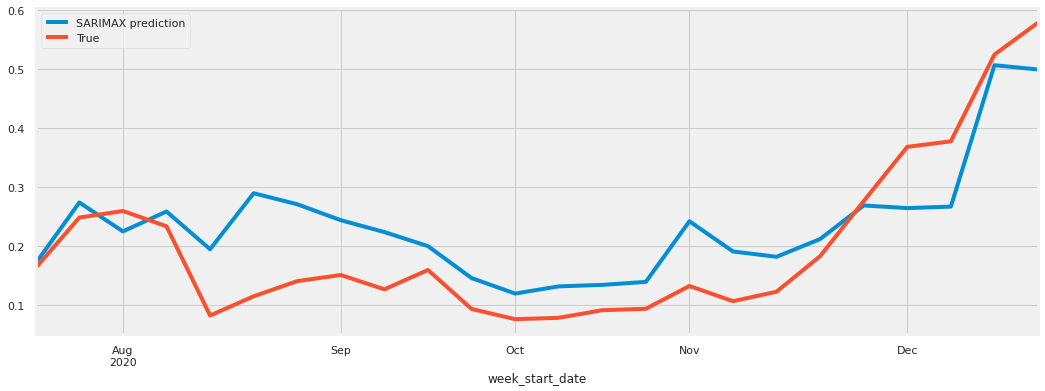

In [226]:
# Forecast plot
fig, ax = plt.subplots(figsize=(16,6))
y_pred_weight.plot(legend=False)
df_cr_test['JP_total_npu+rpu_rev_28d_cohort'].plot(ax=ax, legend=False)
plt.legend(['SARIMAX prediction', 'True'])
plt.show()

### Variable weights

In [264]:
weight_features = ['JP_offnetdisplay_Clicks', 'JP_gdn_Clicks',  'JP_dv360_Clicks']

In [257]:
weight_grid = [0.1, 0.5, 0.9]

In [258]:
import itertools

In [261]:
exog_weights_1 = list(itertools.product(weight_grid, repeat=3))

## SARIMAX Grid Search

In [191]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 3
# Generate all different combinations of p, q and q triplets
p = range(0, 4)
q = range(0, 2)
d = range(0, 1)

pdq = list(itertools.product(p, d, q))

s = [1, 4, 13, 26]
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p, d, q, s))]

In [ ]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_cr_train[y_target_name],\
                                            exog=df_cr_train[curated_features],\
                                            order=param,\
                                            seasonal_order=param_seasonal,\
                                            enforce_invertibility=False)
            results = mod.fit(method='nm')
            print('ARIMA{}X{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

## XGBoost on curated features

In [202]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    # Define model
    model = XGBRegressor(**param)
    
    # Train and test
    X_train = df_cr_train[curated_new]
    y_train = df_cr_train[y_target_name]
    X_test = df_cr_test[curated_new]
    y_test = df_cr_test[y_target_name]
    
    # Fit
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    return mean_squared_error(y_test, y_pred)

In [ ]:
# Create the study
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=100)

print('Best parameters', study.best_params)

In [302]:
# Train and test
X_train = df_cr_train[curated_new]
y_train = df_cr_train[y_target_name]
X_test = df_cr_test[curated_new]
y_test = df_cr_test[y_target_name]

model = XGBRegressor(**study.best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAPE: ', mape(y_test, y_pred))

# Model evaluation
print(f"XGB r-squared training {model.score(X_train,y_train):.3f}")
print(f"XGB r-squared test {model.score(X_test,y_test):.3f}")

MSE:  0.0052820910672658474
RMSE:  0.07267799575707799
MAPE:  39.9384777737573
XGB r-squared training 0.844
XGB r-squared test 0.714


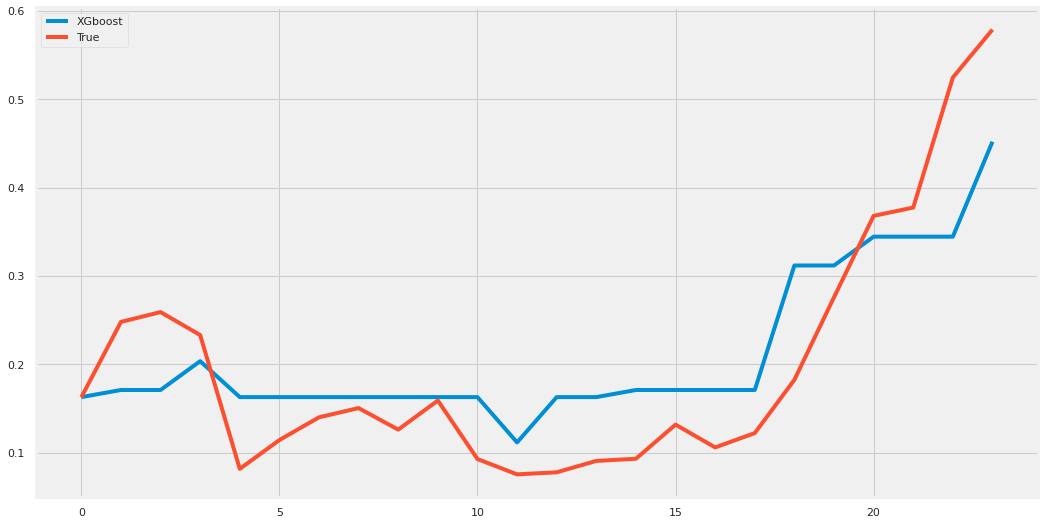

In [205]:
plt.plot(y_pred)
plt.plot(y_test.values)
plt.legend(['XGboost', 'True'])

In [206]:
import shap

In [207]:
test_shap = shap.TreeExplainer(model).shap_values(X_test)

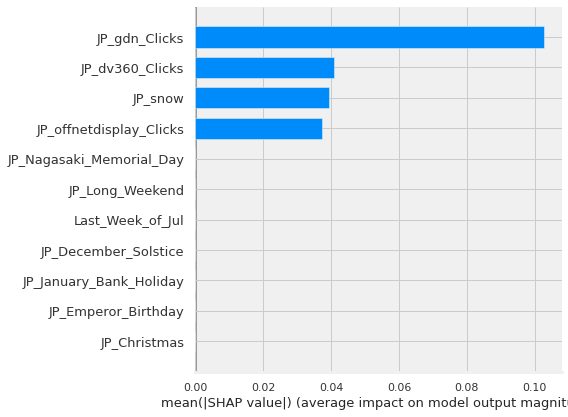

In [208]:
shap.summary_plot(test_shap, X_test, plot_type="bar")

### Reproducing previous work (best model based on impressions)

In [209]:
previous_features = ['JP_dv360_Impressions_lag_3', 'JP_gdn_Impressions', 'JP_offnetdisplay_Impressions', 'JP_onnetsem_Impressions', 'JP_video_Impressions', 'JP_rained_on_weekend_1', 'JP_Christmas', 'JP_December_Solstice', 'JP_New_Year', 'JP_Last_Week_of_Month', 'JP_deaths_all_ages', 'JP_game_launches']

In [214]:
df_imp_revenue = pd.concat([df[previous_features], y_target_revenue], axis=1, join='inner')

In [216]:
nobs = 24
df_imp_train, df_imp_test = df_imp_revenue[0:-nobs], df_imp_revenue[-nobs:]

In [219]:
sarimax_previous = sm.tsa.SARIMAX(df_imp_train['JP_total_npu+rpu_rev_28d_cohort'],\
                                exog=df_imp_train[previous_features],\
                                order=(1,0,0),\
                                seasonal_order=(1,0,1,52),\
                                enforce_invertibility=False)

sarimax_previous_res = sarimax_previous.fit()
sarimax_previous_res.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.46539D+00    |proj g|=  7.11737D-01

At iterate    5    f= -1.49504D+00    |proj g|=  1.05093D+00

At iterate   10    f= -1.51590D+00    |proj g|=  1.03706D+00

At iterate   15    f= -1.52648D+00    |proj g|=  4.32572D-01

At iterate   20    f= -1.53256D+00    |proj g|=  1.18261D-01

At iterate   25    f= -1.53636D+00    |proj g|=  1.45216D-01

At iterate   30    f= -1.53920D+00    |proj g|=  4.02425D-02

At iterate   35    f= -1.53977D+00    |proj g|=  1.78995D-02

At iterate   40    f= -1.53984D+00    |proj g|=  3.91493D-02

At iterate   45    f= -1.54004D+00    |proj g|=  5.40829D-02

At iterate   50    f= -1.54008D+00    |proj g|=  7.54947D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:      JP_total_npu+rpu_rev_28d_cohort   No. Observations:                   98
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 52)   Log Likelihood                 150.928
Date:                              Wed, 15 Mar 2023   AIC                           -269.856
Time:                                      01:03:53   BIC                           -228.497
Sample:                                  09-03-2018   HQIC                          -253.127
                                       - 07-13-2020                                         
Covariance Type:                                opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
JP_dv360_Impressions_lag_3       0.0273      0.062      0.444      0.657      -0.093       0.148
JP_gdn_Impressions               0.2095      0.147      1.428      0.153      -0.078       0.497
JP_offnetdisplay_Impressions     0.3549      0.044      8.121      0.000       0.269       0.441
JP_onnetsem_Impressions          0.1241      0.075      1.645      0.100      -0.024       0.272
JP_video_Impressions             0.0814      0.057      1.421      0.155      -0.031       0.194
JP_rained_on_weekend_1          -0.0132      0.011     -1.223      0.221      -0.034       0.008
JP_Christmas                     0.3419      0.070      4.899      0.000       0.205       0.479
JP_December_Solstice             0.0957      0.090      1.067      0.286      -0.080       0.271
JP_New_Year                      0.1713      0.054      3.165      0.002       0.065       0.277
JP_Last_Week_of_Month           -0.0043      0.015     -0.284      0.777      -0.034       0.025
JP_deaths_all_ages              -0.0672      0.036     -1.861      0.063      -0.138       0.004
JP_game_launches                -0.0263      0.020     -1.284      0.199      -0.066       0.014
ar.L1                            0.6783      0.090      7.538      0.000       0.502       0.855
ar.S.L52                         0.0586    108.623      0.001      1.000    -212.839     212.957
ma.S.L52                         0.0597    110.167      0.001      1.000    -215.863     215.983
sigma2                           0.0026      0.001      4.102      0.000       0.001       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 7.09
Prob(Q):                              0.64   Prob(JB):                         0.03
Heteroskedasticity (H):               0.71   Skew:                             0.24
Prob(H) (two-sided):                  0.34   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [222]:
y_test = df_imp_test['JP_total_npu+rpu_rev_28d_cohort']
test_predict = sarimax_previous_res.predict(start=df_imp_test.index[0], end=df_imp_test.index[23], exog=df_imp_test[previous_features])

print(f"SARIMAX training MAE {sarimax_previous_res.mae:.3f}")
print(f"SARIMAX test MAE {mae(y_test.values, test_predict.values):.3f}")
print(f"SARIMAX test MSE {mean_squared_error(y_test.values, test_predict.values):.3f}")
print(f"SARIMAX test MAPE {mape(y_test.values, test_predict.values):.3f}")
print(f"SARIMAX test RMSPE {rmse(y_test.values, test_predict.values):.3f}")

SARIMAX training MAE 0.038
SARIMAX test MAE 0.079
SARIMAX test MSE 0.010
SARIMAX test MAPE 48.540
SARIMAX test RMSPE 0.608


In [223]:
previous_features

['JP_dv360_Impressions_lag_3',
 'JP_gdn_Impressions',
 'JP_offnetdisplay_Impressions',
 'JP_onnetsem_Impressions',
 'JP_video_Impressions',
 'JP_rained_on_weekend_1',
 'JP_Christmas',
 'JP_December_Solstice',
 'JP_New_Year',
 'JP_Last_Week_of_Month',
 'JP_deaths_all_ages',
 'JP_game_launches']

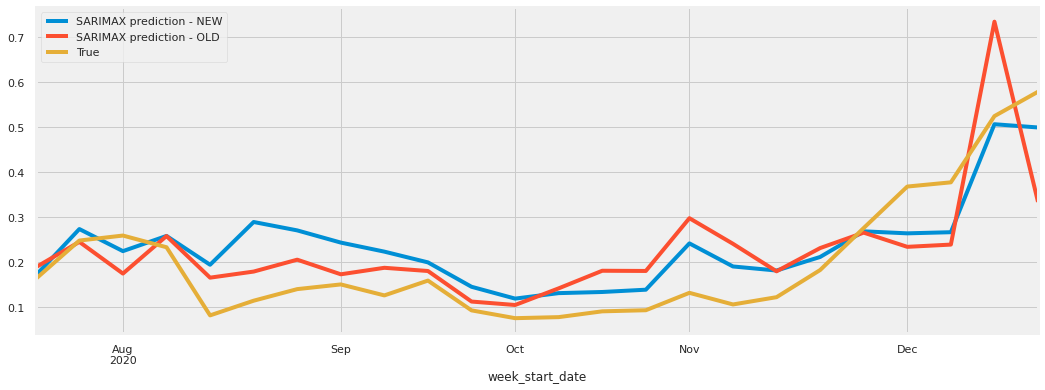

In [227]:
# Forecast plot
fig, ax = plt.subplots(figsize=(16,6))
y_pred_weight.plot(ax=ax, legend=False)
sarimax_previous_res.predict(ax=ax, start=df_cr_test.index[0], end=df_imp_test.index[nobs-1], exog=df_imp_test[previous_features]).plot(legend=False)
df_imp_test['JP_total_npu+rpu_rev_28d_cohort'].plot(ax=ax, legend=False)
plt.legend(['SARIMAX prediction - NEW', 'SARIMAX prediction - OLD', 'True'])
plt.show()

In [247]:
for nob in [3, 7, 11, 15, 19, 23]:
    y_test = df_imp_revenue[-(nob+1):]['JP_total_npu+rpu_rev_28d_cohort']
    test_predict = sarimax_previous_res.predict(start=df_imp_test.index[0], end=df_imp_test.index[nob], exog= df_imp_revenue[-(nob+1):][previous_features])
    print(f"SARIMAX test MAPE {mape(y_test.values, test_predict.values):.3f}")


SARIMAX test MAPE 33.192
SARIMAX test MAPE 60.444
SARIMAX test MAPE 80.740
SARIMAX test MAPE 65.947
SARIMAX test MAPE 64.111
SARIMAX test MAPE 48.540


In [250]:
for nob in [3, 7, 11, 15, 19, 23]:
    y_test = df_clicks_revenue[-(nob+1):]['JP_total_npu+rpu_rev_28d_cohort']
    test_predict = sarimax_weighted.predict(start=df_cr_test.index[0], end=df_cr_test.index[nob], exog= df_clicks_revenue[-(nob+1):][curated_new])
    print(f"SARIMAX test MAPE {mape(y_test.values, test_predict.values):.3f}")

SARIMAX test MAPE 15.543
SARIMAX test MAPE 31.695
SARIMAX test MAPE 44.709
SARIMAX test MAPE 46.620
SARIMAX test MAPE 59.144
SARIMAX test MAPE 48.828


In [311]:
all_mape_old = np.array([33.192, 60.444, 80.740, 65.947, 64.111, 48.54])
all_mape_new = np.array([15.543, 31.695, 44.709, 46.620, 59.144, 48.828])

In [329]:
forecast_list = [0, '4-week ahead', '8-week ahead', '12-week ahead', '16-week ahead', '20-week ahead', '24-week ahead']

In [330]:
forecast_list

[0,
 '4-week ahead',
 '8-week ahead',
 '12-week ahead',
 '16-week ahead',
 '20-week ahead',
 '24-week ahead']

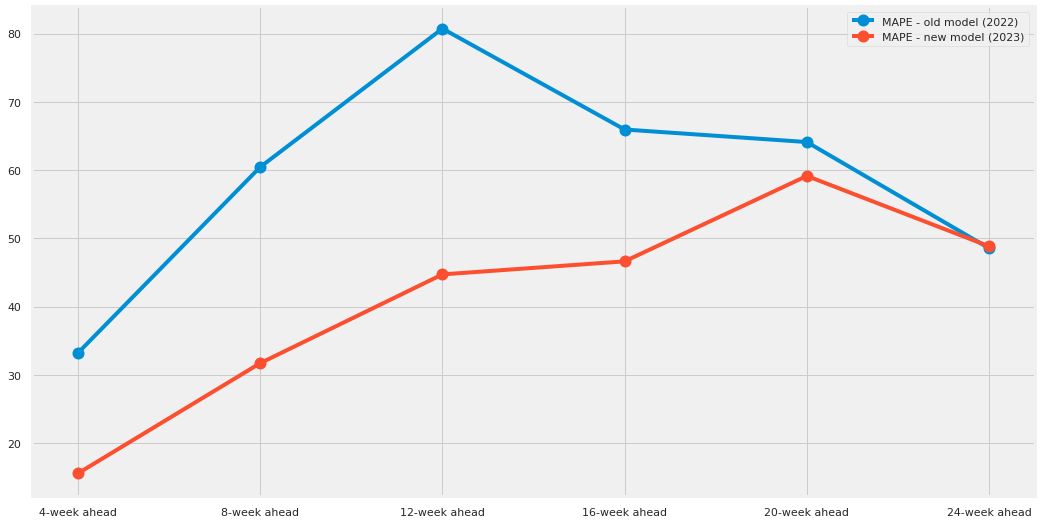

In [331]:
#fig, ax = plt.subplots(figsize=(16,6))
ax = plt.axes()
plt.plot(all_mape_old, marker='o', markersize=12)
plt.plot(all_mape_new, marker='o', markersize=12)
plt.legend(['MAPE - old model (2022)', 'MAPE - new model (2023)'])
ax.set_xticklabels(forecast_list)
plt.show()

In [251]:
y_ewma_revenue = y_target_revenue.ewm(alpha=0.6).mean()

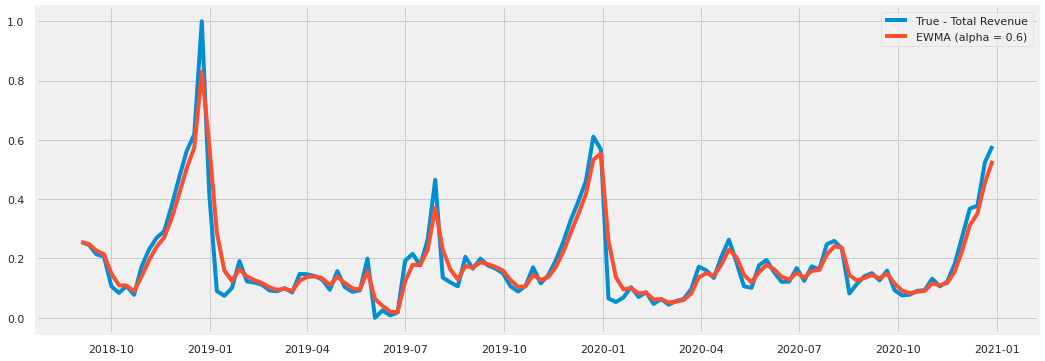

In [254]:
fig, ax = plt.subplots(figsize=(16,6))
plt.plot(y_target_revenue)
plt.plot(y_ewma_revenue)
plt.legend(['True - Total Revenue', 'EWMA (alpha = 0.6)'])
plt.show()

In [256]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [257]:
ewm_model = SimpleExpSmoothing(y_target_revenue[0:-nobs])

In [258]:
ewm_results = ewm_model.fit(smoothing_level=0.6, optimized=False)
ewm_predictions = ewm_results.forecast(steps=24)

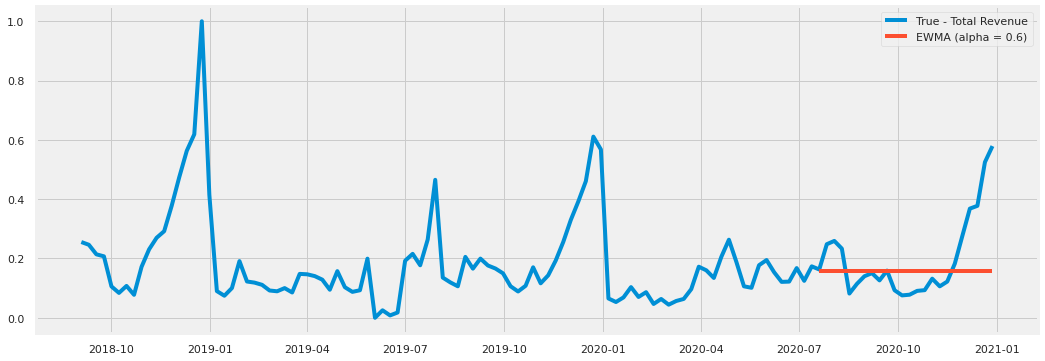

In [259]:
fig, ax = plt.subplots(figsize=(16,6))
plt.plot(y_target_revenue)
plt.plot(ewm_predictions)
plt.legend(['True - Total Revenue', 'EWMA (alpha = 0.6)'])
plt.show()

In [260]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [286]:
hw_model = ExponentialSmoothing(y_target_revenue[0:-nobs], seasonal='add', seasonal_periods=12).fit()

In [287]:
hw_pred = hw_model.predict(start=y_target_revenue[-nobs:].index[0], end=y_target_revenue[-nobs:].index[-1])

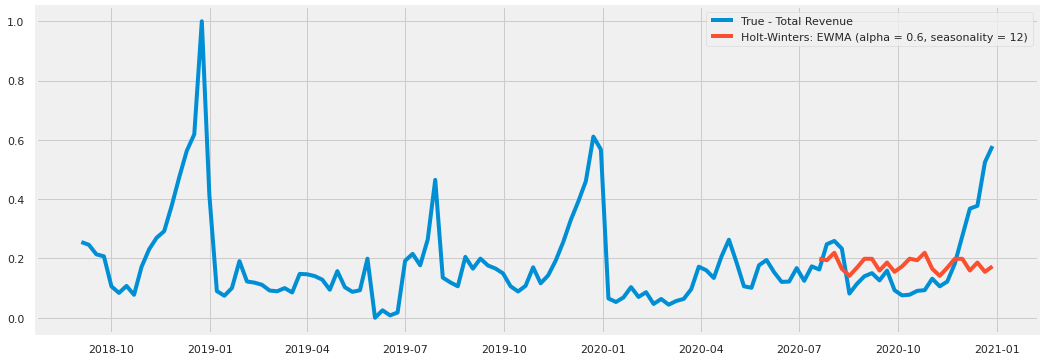

In [288]:
fig, ax = plt.subplots(figsize=(16,6))
plt.plot(y_target_revenue)
plt.plot(hw_pred)
plt.legend(['True - Total Revenue', 'Holt-Winters: EWMA (alpha = 0.6, seasonality = 12)'])
plt.show()

In [290]:
mape(hw_pred, y_target_revenue[-nobs:])

56.83381721093787

In [292]:
mape(ewm_predictions, y_target_revenue[-nobs:])

60.143094129865304